In [152]:
# LIBRARIES
import numpy as np
import pandas as pd
import sklearn
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import optuna
import joblib
import re

# PREPROCESSING AND EVALUATION
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from scipy.stats import norm
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PowerTransformer
from sklearn.metrics import mean_squared_error

# REGRESSION
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso

# OTHER
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Creating Functions
Let's create a few functions for extra convenience down the road.

In [2]:
# creates a correlation matrix with rows and columns sorted by correlation with the target in descending order
def plot_corr_matrix(df, num_columns: [list(), 'all'], target, abs_val: [0,1]):
    if num_columns == 'all':
        num_columns = df.select_dtypes('number').columns.tolist()
    if target not in num_columns:
        num_columns.append(target)
    corr = df[num_columns].corr().sort_values(target, ascending=False).sort_values(target, axis=1, ascending=False)
    corr_abs = df[num_columns].corr().abs().sort_values(target, ascending=False).sort_values(target, axis=1, ascending=False)
    
    plt.figure(figsize=(len(num_columns)*0.5, len(num_columns)*0.5))
    sns.set(font_scale=1.25)
    
    if abs_val==0:
        plt.title('Correlations b/n pairs of numeric predictors (sorted by correlations with {})'.format(target))        
        sns.heatmap(corr, linewidths=1.5, annot=True, square=True, fmt='.2f', annot_kws={'size': 10-len(num_columns)*0.03}, 
                    yticklabels=corr.index, xticklabels=corr.index, vmin=-1, vmax=1, cmap='coolwarm', cbar_kws={"shrink": .5})
    elif abs_val==1:
        plt.title('ABS VALUES of correlations b/n pairs of numeric predictors (sorted by correlations with {})'.format(target))  
        sns.heatmap(corr_abs, linewidths=1.5, annot=True, square=True, fmt='.2f', annot_kws={'size': 10-len(num_columns)*0.03}, 
                    yticklabels=corr_abs.index, xticklabels=corr_abs.index, vmin=0, vmax=1, cmap='Reds', cbar_kws={"shrink": .5})

# creates a barplot of correlations with the target, sorted in descending order
def plot_corr_barplot(df, num_columns, target, abs_val: [0,1]):
    if num_columns == 'all':
        num_columns = df.select_dtypes('number').columns.tolist()
    if target not in num_columns:
        num_columns.append(target)
    corr = df[num_columns].corr()[target].sort_values(ascending=False)
    corr_abs = df[num_columns].corr().abs()[target].sort_values(ascending=False)
    
    plt.figure(figsize=(len(num_columns)*0.5, len(num_columns)*0.5))
    sns.set(font_scale=1.25)
    
    if abs_val==0:  
        plt.title('Correlations of numeric predictors with {}'.format(target))
        sns.barplot(corr.values, corr.index)
    elif abs_val==1:
        plt.title('ABS VALUES of correlations of numeric predictors with {}'.format(target))
        sns.barplot(corr_abs.values, corr_abs.index)

# function for univariate analysis of numerical variables
# outputs a handful of descriptive statistics and a histogram and a box plot
def num_univariate(df, target):
    stats = {'Number of unique values': df[target].nunique(),
             'Minimum': round(df[target].min(), 2),
             'Maximum': round(df[target].max(), 2),
             'Range': round(df[target].max()-df[target].min(), 2),
             'Skewness': round(df[target].skew(), 2),
             'Kurtosis': round(df[target].kurt(), 2)}
    stats = pd.DataFrame(stats.values(), index=stats.keys(), columns=[target])
    display(stats)
    
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(2,1,1, title='{} distribution vs. Gaussian distribution'.format(target))
    sns.distplot(df[target], fit=norm)
    ax1.tick_params(axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    labelbottom=False) # labels along the bottom edge are off
    ax1.set_xlabel('')
    ax2 = fig.add_subplot(2,1,2, sharex=ax1, title='{} distribution'.format(target))
    sns.boxplot(df[target])

# function for bivariate analysis of categorical variables
# outputs either a box plot or a swarm plot
def cat_bivariate(df, cat_col, num_target, kind=['box', 'swarm']):
    order = df.groupby(cat_col)[num_target].median().sort_values(ascending=False).index
    plt.figure(figsize=(15,6))
    if kind=='box':
        plt.title('Distributions of {} by categories of {}, sorted by medians'.format(num_target, cat_col))
        sns.boxplot(cat_col, num_target, data=df, order=order)
    elif kind=='swarm':
        plt.title('Distributions and counts of {} by categories of {}, sorted by medians'.format(num_target, cat_col))
        sns.swarmplot(cat_col, num_target, data=df, order=order)
    plt.tick_params(axis='x', labelrotation=45)

# function for nominal-categorical * numerical feature engineering (e.g., neighborhood * plot area)
def nom__num(df_train, other_dfs: [], nom_col, num_col):
    vals = df_train[nom_col].value_counts().index.tolist()
    for val in vals:
        colname = nom_col+'_'+val+'__'+num_col
        # to avoid data leakage:
        # create a new column in all three datasets for every unique value in nom_col of *df_train*
        # assumes num_col is encoded as a number
        df_train[colname] = (df_train[nom_col]==val)*1 * df_train[num_col]
        for i in other_dfs:
            i[colname] = (i[nom_col]==val)*1 * i[num_col]
        # if a column with this name already exists, it will be overwritten

# renames columns of dataframe of Optuna study trials (contains hyper-parameter values and error scores)
def rename_columns(study_df):
    # removes 'params_' from column names
    for c in study_df.columns.tolist():
        if re.search("params_", c):
            new_name = re.search("params_(.+)", c).group(1)
            study_df.rename(columns={c: new_name}, inplace=True)

# Dataset Loading and Cleaning
Before we do anything, we need to clean the data and perform a few sanity checks. If something is  wrong, we need to find the reason and clean the data some more.

In [3]:
house_prices = pd.read_csv('train.csv')
predict = pd.read_csv('test.csv')
all = pd.concat([house_prices, predict], sort=False)
predict_ids = predict.Id # will be used in the submission file at the very end

house_prices.shape
predict.shape
all.head()

(1460, 81)

(1459, 80)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ       706.0          Unf         0.0      150.0        856.0   
1          ALQ       978.0          Unf         0.0      284.0       1262.0   
2          GLQ       486.0          Unf         0.0      434.0        920.0   
3          ALQ       216.0          Unf         0.0      540.0        756.0   
4          GLQ       655.0          Unf         0.0      490.0       1145.0   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710           1.0           0.0         2         1             3   
1       1262           0.0           1.0         2         0             3   
2       1786           1.0           0.0         2         1             3   
3       1717           1.0           0.0         1         0             3   
4       2198           1.0           0.0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [4]:
# let's look at the txt file with feature descriptions and decide how we want to use each one
# numerical features
num_feats = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
                'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
               'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
                'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

# cagegorical features: nominal and ordinal
# nominal features will be one-hot encoded and will be processed using the *nominal* pipeline later on
# ordinal features will be encoded as numbers (integers) and will be processed using the *numerical* pipeline later on
nom_feats = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
                'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
                'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType',
                'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']

ord_feats = ['Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu',
                'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC']

# remaining columns: Id, SalePrice

len(num_feats), len(nom_feats), len(ord_feats)
len(num_feats + nom_feats + ord_feats)

(33, 28, 18)

79

As we can see below, the data types are wrong for some categorical (nominal and ordinal) features. Hence, we will change the data types of these columns to 'object'. Later, the values of ordinal categorical features will be mapped to numbers.

In [5]:
print('Number of numerical features encoded as strings:', all[num_feats].select_dtypes(exclude='number').columns.shape[0])
print('Number of categorical features encoded as numbers:', all[nom_feats + ord_feats].select_dtypes(exclude='object').columns.shape[0])

Number of numerical features encoded as strings: 0
Number of categorical features encoded as numbers: 3


In [6]:
all[nom_feats + ord_feats] = all[nom_feats + ord_feats].astype('object')
house_prices[nom_feats + ord_feats] = house_prices[nom_feats + ord_feats].astype('object')
predict[nom_feats + ord_feats] = predict[nom_feats + ord_feats].astype('object')

print('Number of numerical features encoded as strings:', all[num_feats].select_dtypes(exclude='number').columns.shape[0])
print('Number of categorical features encoded as numbers:', all[nom_feats + ord_feats].select_dtypes(exclude='object').columns.shape[0])

Number of numerical features encoded as strings: 0
Number of categorical features encoded as numbers: 0


In [7]:
# check if there are any features with zero variance (features that have exactly one unique value) in the training
# set; they are useless since they have nothing to teach a model
sum((house_prices.nunique(axis=0)==1)*1)

# check if there are any duplicate ids
house_prices.Id.duplicated().sum()

# check if there are any samples that are exactly the same except for their ids
house_prices.drop('Id', axis=1).duplicated().sum()

0

0

0

# Handle Missing Values

In this step, we will perform missing value sanity checks, impute missing values that are result of what Kjell and Johnson call "structural deficiencies," and prepare other types (MCAR or MAR) of missing values for imputation later in the project.

The sanity checks consist of making sure that the values (or lack thereof) of some attibutes make sense in combination with the values of other attributes. For instance, columns XXXXX and XXXXX should both have missing values when a house doesn't have a fireplace. Hence, if only one of them has a missing value, there is a problem.

Kjell and Johnson name three common mechanisms of missing data. They are (1) structural deficiencies in the data, (2) random occurances (MCAR and MAR), and (3) specific causes (MNAR). We will deal with the first type of missing values by imputing them with categories that they stand for. Missing values belonging to the second category will be imputed later in the project using univariate imputation. Fortunately, there are no missing values of type MNAR (the least "innocent" type). So, we do not need to worry about them, as univariate imputation is not appropriate for this category (as is multivariate imputation, in many cases).

In [8]:
all.isna().sum()

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
Alley            2721
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
MasVnrArea         23
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinSF1          1
BsmtFinType2       80
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

In [9]:
all[all.MSZoning.isna()]

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
455   1916         30      NaN        109.0    21780   Grvl   NaN      Reg   
756   2217         20      NaN         80.0    14584   Pave   NaN      Reg   
790   2251         70      NaN          NaN    56600   Pave   NaN      IR1   
1444  2905         20      NaN        125.0    31250   Pave   NaN      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
455          Lvl       NaN    Inside       Gtl       IDOTRR       Norm   
756          Low    AllPub    Inside       Mod       IDOTRR       Norm   
790          Low    AllPub    Inside       Gtl       IDOTRR       Norm   
1444         Lvl    AllPub    Inside       Gtl      Mitchel     Artery   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
455        Norm     1Fam     1Story            2            4       1910   
756        Norm     1Fam     1Story            1            5       1952   
790        Norm     1Fam     2.5Unf            5            1       1900   
1444       Norm     1Fam     1Story            1            3       1951   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
455           1950     Gable  CompShg     Wd Sdng     Wd Sdng       None   
756           1952     Gable  CompShg     AsbShng     VinylSd       None   
790           1950       Hip  CompShg     Wd Sdng     Wd Sdng       None   
1444          1951     Gable  CompShg      CBlock     VinylSd       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
455          0.0        Fa        Fa     CBlock      NaN      NaN   
756          0.0        Fa        Po       Slab      NaN      NaN   
790          0.0        TA        TA     BrkTil       TA       TA   
1444         0.0        TA        Fa     CBlock      NaN      NaN   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
455           NaN          NaN         0.0          NaN         0.0   
756           NaN          NaN         0.0          NaN         0.0   
790            No          Unf         0.0          Unf         0.0   
1444          NaN          NaN         0.0          NaN         0.0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
455         0.0          0.0    GasA        TA          N      FuseA   
756         0.0          0.0    Wall        Po          N      FuseA   
790       686.0        686.0    GasA        Ex          Y      SBrkr   
1444        0.0          0.0    GasA        TA          Y      FuseA   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
455        810         0             0        810           0.0           0.0   
756        733         0             0        733           0.0           0.0   
790       1150       686             0       1836           0.0           0.0   
1444      1600         0             0       1600           0.0           0.0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
455          1         0             1             1          TA   
756          1         0             2             1          Fa   
790          2         0             4             1          TA   
1444         1         1             3             1          TA   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
455              4       Min1           0         NaN     Detchd       1975.0   
756              4        NaN           0         NaN     Attchd       1952.0   
790              7       Maj1           0         NaN     Detchd       1900.0   
1444             6        Mod           0         NaN     Attchd       1951.0   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
455           Unf         1.0       280.0         TA         TA          N   
756           Unf         2.0       487.0         Fa         Po          N   
790           Unf         1.0     

Missing values in MSZoning are most likely MCAR, or at least MAR. In either case univariate imputation is an appropriate technique for handling these missing values.

In [10]:
all[all.LotFrontage.isna()]

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
7        8         60       RL          NaN    10382   Pave   NaN      IR1   
12      13         20       RL          NaN    12968   Pave   NaN      IR2   
14      15         20       RL          NaN    10920   Pave   NaN      IR1   
16      17         20       RL          NaN    11241   Pave   NaN      IR1   
24      25         20       RL          NaN     8246   Pave   NaN      IR1   
31      32         20       RL          NaN     8544   Pave   NaN      IR1   
42      43         85       RL          NaN     9180   Pave   NaN      IR1   
43      44         20       RL          NaN     9200   Pave   NaN      IR1   
50      51         60       RL          NaN    13869   Pave   NaN      IR2   
64      65         60       RL          NaN     9375   Pave   NaN      Reg   
66      67         20       RL          NaN    19900   Pave   NaN      Reg   
76      77         20       RL          NaN     8475   Pave   NaN      IR1   
84      85         80       RL          NaN     8530   Pave   NaN      IR1   
95      96         60       RL          NaN     9765   Pave   NaN      IR2   
100    101         20       RL          NaN    10603   Pave   NaN      IR1   
104    105         50       RM          NaN     7758   Pave   NaN      Reg   
111    112         80       RL          NaN     7750   Pave   NaN      IR1   
113    114         20       RL          NaN    21000   Pave   NaN      Reg   
116    117         20       RL          NaN    11616   Pave   NaN      Reg   
120    121         80       RL          NaN    21453   Pave   NaN      IR1   
126    127        120       RL          NaN     4928   Pave   NaN      IR1   
131    132         60       RL          NaN    12224   Pave   NaN      IR1   
133    134         20       RL          NaN     6853   Pave   NaN      IR1   
136    137         20       RL          NaN    10355   Pave   NaN      IR1   
147    148         60       RL          NaN     9505   Pave   NaN      IR1   
149    150         50       RM          NaN     6240   Pave   NaN      Reg   
152    153         60       RL          NaN    14803   Pave   NaN      IR1   
153    154         20       RL          NaN    13500   Pave   NaN      Reg   
160    161         20       RL          NaN    11120   Pave   NaN      IR1   
166    167         20       RL          NaN    10708   Pave   NaN      IR1   
169    170         20       RL          NaN    16669   Pave   NaN      IR1   
170    171         50       RM          NaN    12358   Pave   NaN      IR1   
177    178         50       RL          NaN    13650   Pave   NaN      Reg   
180    181        160       FV          NaN     2117   Pave   NaN      Reg   
186    187         80       RL          NaN     9947   Pave   NaN      IR1   
191    192         60       RL          NaN     7472   Pave   NaN      IR1   
203    204        120       RM          NaN     4438   Pave   NaN      Reg   
207    208         20       RL          NaN    12493   Pave   NaN      IR1   
208    209         60       RL          NaN    14364   Pave   NaN      IR1   
214    215         60       RL          NaN    10900   Pave   NaN      IR1   
218    219         50       RL          NaN    15660   Pave   NaN      IR1   
221    222         60       RL          NaN     8068   Pave   NaN      IR1   
234    235         60       RL          NaN     7851   Pave   NaN      Reg   
237    238         60       RL          NaN     9453   Pave   NaN      IR1   
244    245         60       RL          NaN     8880   Pave   NaN      IR1   
249    250         50       RL          NaN   159000   Pave   NaN      IR2   
269    270         20       RL          NaN     7917   Pave   NaN      IR1   
287    288         20       RL          NaN     8125   Pave   NaN      IR1   
288    289         20       RL          NaN     9819   Pave   NaN      IR1   
293    294         60       RL          NaN    16659   Pave   NaN      IR1   
307    308         50       RM

From all the information we are given, it is unclear whether missing values in LotFrontage are result of a structural deficiency (i.e., the property does not have direct access to a street) or are missing for some other reason. It's very unlikely that they are MNAR. Hence, they are either MCAR or MAR.

According to the accompanying txt file, missing values in the Alley column are result of a structural deficiency: they stand for "No alley access". Hence, we replace them with "None".

In [11]:
all.Alley.fillna('None', inplace=True)

In [12]:
all[all.Utilities.isna()]

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
455  1916         30      NaN        109.0    21780   Grvl  None      Reg   
485  1946         20       RL          NaN    31220   Pave  None      IR1   

    LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
455         Lvl       NaN    Inside       Gtl       IDOTRR       Norm   
485         Bnk       NaN       FR2       Gtl      Gilbert      Feedr   

    Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
455       Norm     1Fam     1Story            2            4       1910   
485       Norm     1Fam     1Story            6            2       1952   

     YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
455          1950     Gable  CompShg     Wd Sdng     Wd Sdng       None   
485          1952       Hip  CompShg     BrkFace     BrkFace       None   

     MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
455         0.0        Fa        Fa     CBlock      NaN      NaN          NaN   
485         0.0        TA        TA     CBlock       TA       TA           No   

    BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
455          NaN         0.0          NaN         0.0        0.0          0.0   
485          Unf         0.0          Unf         0.0     1632.0       1632.0   

    Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
455    GasA        TA          N      FuseA       810         0             0   
485    GasA        TA          Y      FuseA      1474         0             0   

     GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
455        810           0.0           0.0         1         0             1   
485       1474           0.0           0.0         1         0             3   

     KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces  \
455             1          TA             4       Min1           0   
485             1          TA             7       Min2           2   

    FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea  \
455         NaN     Detchd       1975.0          Unf         1.0       280.0   
485          Gd     Attchd       1952.0          Unf         2.0       495.0   

    GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  \
455         TA         TA          N         119           24              0   
485         TA         TA          Y           0            0            144   

     3SsnPorch  ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  \
455          0            0         0    NaN   NaN         NaN        0   
485          0            0         0    NaN   NaN        Shed      750   

    MoSold YrSold SaleType SaleCondition  SalePrice  
455      3   2009    ConLD        Normal        NaN  
485      5   2008       WD        Normal        NaN

Missing values in the Utilities column are most likely MCAR, or at least MAR. We will deal with them later.

In [13]:
all[all.Exterior1st.isna() | all.Exterior2nd.isna()]

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
691  2152         30       RL         85.0    19550   Pave  None      Reg   

    LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
691         Lvl    AllPub    Inside       Gtl      Edwards       Norm   

    Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
691       Norm     1Fam     1Story            5            7       1940   

     YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
691          2007      Flat  Tar&Grv         NaN         NaN       None   

     MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
691         0.0        TA        TA      PConc       TA       TA           Gd   

    BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
691          ALQ      1035.0          Unf         0.0      545.0       1580.0   

    Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
691    GasA        Ex          Y      SBrkr      1518         0             0   

     GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
691       1518           1.0           0.0         1         0             2   

     KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces  \
691             1          Fa             5        Typ           2   

    FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea  \
691          Gd        NaN          NaN          NaN         0.0         0.0   

    GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  \
691        NaN        NaN          Y           0           39              0   

     3SsnPorch  ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  \
691          0            0         0    NaN   NaN         NaN        0   

    MoSold YrSold SaleType SaleCondition  SalePrice  
691      1   2008       WD        Normal        NaN

Missing values in the MasVnrType column stand for "None", that is, there is no masonry veneer in the house (structural deficiency). Logically, if a row has a missing value in MasVnrType and in MasVnrArea, we can assume that these values are indeed missing because of the structural deficiency. However, if only one of these two columns has a missing value, this value is likely MCAR or MAR. We can see one sample like this below. Again, MCAR/MAR-type missing values will be dealth with in a later section.

In [14]:
all.loc[all.MasVnrType.isna() & all.MasVnrArea.isna(), ['MasVnrType', 'MasVnrArea']] # structural deficiency
all.loc[all.MasVnrType.isna() ^ all.MasVnrArea.isna(), ['Id', 'MasVnrType', 'MasVnrArea']] # MCAR or MAR

MasVnrType  MasVnrArea
234         NaN         NaN
529         NaN         NaN
650         NaN         NaN
936         NaN         NaN
973         NaN         NaN
977         NaN         NaN
1243        NaN         NaN
1278        NaN         NaN
231         NaN         NaN
246         NaN         NaN
422         NaN         NaN
532         NaN         NaN
544         NaN         NaN
581         NaN         NaN
851         NaN         NaN
865         NaN         NaN
880         NaN         NaN
889         NaN         NaN
908         NaN         NaN
1132        NaN         NaN
1197        NaN         NaN
1226        NaN         NaN
1402        NaN         NaN

Id MasVnrType  MasVnrArea
1150  2611        NaN       198.0

In [15]:
# Replace NaN's in column MasVnrType with 'None' for rows where both columns have a missing value
all.loc[all.MasVnrType.isna() & all.MasVnrArea.isna(), 'MasVnrType'] = 'None'
# Replace NaN's in column MasVnrArea with 0 for rows where MasVnrType is 'None' (not NaN)
all.loc[all.MasVnrArea.isna() & (all.MasVnrType=='None'), 'MasVnrArea'] = 0
# to be imputed later
all.loc[all.MasVnrType.isna() | all.MasVnrArea.isna(), ['MasVnrType', 'MasVnrArea']]

MasVnrType  MasVnrArea
1150        NaN       198.0

NaN's in BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, and BsmtFinType2 all stand for 'No Basement'. Hence, there should be the same number of NaN's in these collumns, and they should be in the same rows. However, they all have have different numbers of missing values. Also, columns BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, and BsmtHalfBath should have zeros in these rows.

If ALL of the above columns (including those that should have zeros) have NaN's in a row, they are likely a structural deficiency. Hence, we will impute them with 'None' and '0'. The rest (MCAR and MAR) will be imputed later.

In [16]:
all.loc[all.BsmtQual.isna() | all.BsmtCond.isna() | all.BsmtExposure.isna() | all.BsmtFinType1.isna() | all.BsmtFinType2.isna() | all.BsmtFinSF1.isna() | all.BsmtFinSF2.isna() | all.BsmtUnfSF.isna() | all.TotalBsmtSF.isna() | all.BsmtFullBath.isna()| all.BsmtHalfBath.isna(),
   ['Id', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']]

Id BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2  \
17      18      NaN      NaN          NaN          NaN          NaN   
39      40      NaN      NaN          NaN          NaN          NaN   
90      91      NaN      NaN          NaN          NaN          NaN   
102    103      NaN      NaN          NaN          NaN          NaN   
156    157      NaN      NaN          NaN          NaN          NaN   
182    183      NaN      NaN          NaN          NaN          NaN   
259    260      NaN      NaN          NaN          NaN          NaN   
332    333       Gd       TA           No          GLQ          NaN   
342    343      NaN      NaN          NaN          NaN          NaN   
362    363      NaN      NaN          NaN          NaN          NaN   
371    372      NaN      NaN          NaN          NaN          NaN   
392    393      NaN      NaN          NaN          NaN          NaN   
520    521      NaN      NaN          NaN          NaN          NaN   
532    533      NaN      NaN          NaN          NaN          NaN   
533    534      NaN      NaN          NaN          NaN          NaN   
553    554      NaN      NaN          NaN          NaN          NaN   
646    647      NaN      NaN          NaN          NaN          NaN   
705    706      NaN      NaN          NaN          NaN          NaN   
736    737      NaN      NaN          NaN          NaN          NaN   
749    750      NaN      NaN          NaN          NaN          NaN   
778    779      NaN      NaN          NaN          NaN          NaN   
868    869      NaN      NaN          NaN          NaN          NaN   
894    895      NaN      NaN          NaN          NaN          NaN   
897    898      NaN      NaN          NaN          NaN          NaN   
948    949       Gd       TA          NaN          Unf          Unf   
984    985      NaN      NaN          NaN          NaN          NaN   
1000  1001      NaN      NaN          NaN          NaN          NaN   
1011  1012      NaN      NaN          NaN          NaN          NaN   
1035  1036      NaN      NaN          NaN          NaN          NaN   
1045  1046      NaN      NaN          NaN          NaN          NaN   
1048  1049      NaN      NaN          NaN          NaN          NaN   
1049  1050      NaN      NaN          NaN          NaN          NaN   
1090  1091      NaN      NaN          NaN          NaN          NaN   
1179  1180      NaN      NaN          NaN          NaN          NaN   
1216  1217      NaN      NaN          NaN          NaN          NaN   
1218  1219      NaN      NaN          NaN          NaN          NaN   
1232  1233      NaN      NaN          NaN          NaN          NaN   
1321  1322      NaN      NaN          NaN          NaN          NaN   
1412  1413      NaN      NaN          NaN          NaN          NaN   
27    1488       Gd       TA          NaN          Unf          Unf   
125   1586      NaN      NaN          NaN          NaN          NaN   
133   1594      NaN      NaN          NaN          NaN          NaN   
269   1730      NaN      NaN          NaN          NaN          NaN   
318   1779      NaN      NaN          NaN          NaN          NaN   
354   1815      NaN      NaN          NaN          NaN          NaN   
387   1848      NaN      NaN          NaN          NaN          NaN   
388   1849      NaN      NaN          NaN          NaN          NaN   
396   1857      NaN      NaN          NaN          NaN          NaN   
397   1858      NaN      NaN          NaN          NaN          NaN   
398   1859      NaN      NaN          NaN          NaN          NaN   
400   1861      NaN      NaN          NaN          NaN          NaN   
455   1916      NaN      NaN          NaN          NaN          NaN   
580   2041       Gd      NaN           Mn          GLQ          Rec   
590   2051      NaN      NaN          NaN          NaN          NaN   
606   2067      NaN      NaN          NaN          NaN          NaN   
608   2069      NaN      NaN    

In [17]:
# Replace NaN's with 'None' in all of these columns for rows where all of the above columns have missing values or 0
all.loc[all.BsmtQual.isna() & all.BsmtCond.isna() & all.BsmtExposure.isna() & all.BsmtFinType1.isna() & all.BsmtFinType2.isna() & (all.BsmtFinSF1==0) & (all.BsmtFinSF2==0) & (all.BsmtUnfSF==0) & (all.TotalBsmtSF==0) & (all.BsmtFullBath==0) & (all.BsmtHalfBath==0),
   ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']] = 'None'
all.loc[all.BsmtQual.isna() | all.BsmtCond.isna() | all.BsmtExposure.isna() | all.BsmtFinType1.isna() | all.BsmtFinType2.isna() | all.BsmtFinSF1.isna() | all.BsmtFinSF2.isna() | all.BsmtUnfSF.isna() | all.TotalBsmtSF.isna() | all.BsmtFullBath.isna()| all.BsmtHalfBath.isna(),
   ['Id', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']]

Id BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2  \
332    333       Gd       TA           No          GLQ          NaN   
948    949       Gd       TA          NaN          Unf          Unf   
27    1488       Gd       TA          NaN          Unf          Unf   
580   2041       Gd      NaN           Mn          GLQ          Rec   
660   2121      NaN      NaN          NaN          NaN          NaN   
725   2186       TA      NaN           No          BLQ          Unf   
728   2189      NaN      NaN          NaN          NaN          NaN   
757   2218      NaN       Fa           No          Unf          Unf   
758   2219      NaN       TA           No          Unf          Unf   
888   2349       Gd       TA          NaN          Unf          Unf   
1064  2525       TA      NaN           Av          ALQ          Unf   

      BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  \
332       1124.0       479.0     1603.0       3206.0           1.0   
948          0.0         0.0      936.0        936.0           0.0   
27           0.0         0.0     1595.0       1595.0           0.0   
580       1044.0       382.0        0.0       1426.0           1.0   
660          NaN         NaN        NaN          NaN           NaN   
725       1033.0         0.0       94.0       1127.0           0.0   
728          0.0         0.0        0.0          0.0           NaN   
757          0.0         0.0      173.0        173.0           0.0   
758          0.0         0.0      356.0        356.0           0.0   
888          0.0         0.0      725.0        725.0           0.0   
1064       755.0         0.0      240.0        995.0           0.0   

      BsmtHalfBath  
332            0.0  
948            0.0  
27             0.0  
580            0.0  
660            NaN  
725            1.0  
728            NaN  
757            0.0  
758            0.0  
888            0.0  
1064           0.0

In [18]:
# assume structural deficiency
all.loc[all.Id.isin([2121,2189]), ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']] = 'None'
all.loc[all.Id.isin([2121,2189]), ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']] = 0
# to be imputed later
all.loc[all.BsmtQual.isna() | all.BsmtCond.isna() | all.BsmtExposure.isna() | all.BsmtFinType1.isna() | all.BsmtFinType2.isna() | all.BsmtFinSF1.isna() | all.BsmtFinSF2.isna() | all.BsmtUnfSF.isna() | all.TotalBsmtSF.isna() | all.BsmtFullBath.isna()| all.BsmtHalfBath.isna(),
   ['Id', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']]

Id BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2  \
332    333       Gd       TA           No          GLQ          NaN   
948    949       Gd       TA          NaN          Unf          Unf   
27    1488       Gd       TA          NaN          Unf          Unf   
580   2041       Gd      NaN           Mn          GLQ          Rec   
725   2186       TA      NaN           No          BLQ          Unf   
757   2218      NaN       Fa           No          Unf          Unf   
758   2219      NaN       TA           No          Unf          Unf   
888   2349       Gd       TA          NaN          Unf          Unf   
1064  2525       TA      NaN           Av          ALQ          Unf   

      BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  \
332       1124.0       479.0     1603.0       3206.0           1.0   
948          0.0         0.0      936.0        936.0           0.0   
27           0.0         0.0     1595.0       1595.0           0.0   
580       1044.0       382.0        0.0       1426.0           1.0   
725       1033.0         0.0       94.0       1127.0           0.0   
757          0.0         0.0      173.0        173.0           0.0   
758          0.0         0.0      356.0        356.0           0.0   
888          0.0         0.0      725.0        725.0           0.0   
1064       755.0         0.0      240.0        995.0           0.0   

      BsmtHalfBath  
332            0.0  
948            0.0  
27             0.0  
580            0.0  
725            1.0  
757            0.0  
758            0.0  
888            0.0  
1064           0.0

Missing values in the Electrical column are most likely MCAR, or at least MAR. We will deal with them later.

In [19]:
all[all.Electrical.isna()]

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1379  1380         80       RL         73.0     9735   Pave  None      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
1379         Lvl    AllPub    Inside       Gtl       Timber       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
1379       Norm     1Fam       SLvl            5            5       2006   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
1379          2007     Gable  CompShg     VinylSd     VinylSd       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
1379         0.0        TA        TA      PConc       Gd       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
1379           No          Unf         0.0          Unf         0.0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
1379      384.0        384.0    GasA        Gd          Y        NaN   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
1379       754       640             0       1394           0.0           0.0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
1379         2         1             3             1          Gd   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
1379             7        Typ           0         NaN    BuiltIn       2007.0   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
1379          Fin         2.0       400.0         TA         TA          Y   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
1379         100            0              0          0            0   

      PoolArea PoolQC Fence MiscFeature  MiscVal MoSold YrSold SaleType  \
1379         0    NaN   NaN         NaN        0      5   2008       WD   

     SaleCondition  SalePrice  
1379        Normal   167500.0

Missing values in the KitchenQual column are most likely MCAR, or at least MAR. We will deal with them later.

In [20]:
all[all.KitchenQual.isna()]

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
95  1556         50       RL         72.0    10632   Pave  None      IR1   

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
95         Lvl    AllPub    Inside       Gtl      ClearCr       Norm   

   Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
95       Norm     1Fam     1.5Fin            5            3       1917   

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
95          1950     Gable  CompShg     Wd Sdng     Wd Sdng       None   

    MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
95         0.0        TA        TA     BrkTil       Gd       Fa           No   

   BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
95          Unf         0.0          Unf         0.0      689.0        689.0   

   Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
95    GasA        Gd          N      SBrkr       725       499             0   

    GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
95       1224           0.0           0.0         1         1             3   

    KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
95             1         NaN             6        Mod           0         NaN   

   GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual  \
95     Detchd       1917.0          Unf         1.0       180.0         Fa   

   GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
95         Fa          N           0            0            248          0   

    ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal MoSold YrSold  \
95            0         0    NaN   NaN         NaN        0      1   2010   

   SaleType SaleCondition  SalePrice  
95      COD        Normal        NaN

Missing values in the Functional column are most likely MCAR, or at least MAR. We will deal with them later.

In [21]:
all[all.Functional.isna()]

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
756   2217         20      NaN         80.0    14584   Pave  None      Reg   
1013  2474         50       RM         60.0    10320   Pave  Grvl      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
756          Low    AllPub    Inside       Mod       IDOTRR       Norm   
1013         Lvl    AllPub    Corner       Gtl       IDOTRR     Artery   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
756        Norm     1Fam     1Story            1            5       1952   
1013       Norm     1Fam     1.5Fin            4            1       1910   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
756           1952     Gable  CompShg     AsbShng     VinylSd       None   
1013          1950     Gable  CompShg     Wd Sdng     Wd Sdng       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
756          0.0        Fa        Po       Slab     None     None   
1013         0.0        Fa        Fa     CBlock       TA       Fa   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
756          None         None         0.0         None         0.0   
1013           No          Unf         0.0          Unf         0.0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
756         0.0          0.0    Wall        Po          N      FuseA   
1013      771.0        771.0    GasA        Fa          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
756        733         0             0        733           0.0           0.0   
1013       866       504           114       1484           0.0           0.0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
756          1         0             2             1          Fa   
1013         2         0             3             1          TA   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
756              4        NaN           0         NaN     Attchd       1952.0   
1013             6        NaN           0         NaN     Detchd       1910.0   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
756           Unf         2.0       487.0         Fa         Po          N   
1013          Unf         1.0       264.0         TA         Fa          N   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
756            0            0              0          0            0   
1013          14          211              0          0           84   

      PoolArea PoolQC Fence MiscFeature  MiscVal MoSold YrSold SaleType  \
756          0    NaN   NaN         NaN        0      2   2008       WD   
1013         0    NaN   NaN         NaN        0      9   2007      COD   

     SaleCondition  SalePrice  
756        Abnorml        NaN  
1013       Abnorml        NaN

NaN's in FireplaceQu stand for "No Fireplace" (structural deficiency). Hence, for these rows, there should be 0 in the Fireplaces column, meaning there is no fireplaces. As we can see below, there are no rows where this is not so. Hence, we can replce all NaN's in FireplaceQu with 'None'.

In [22]:
all.loc[(all.Fireplaces==0) ^ all.FireplaceQu.isna()].shape[0]

0

In [23]:
# replace NaN's in FireplaceQu with 'None'
all.FireplaceQu.fillna('None', inplace=True)

NaN's in columns GarageType, GarageYrBlt, GarageFinish, GarageQual, and GarageCond stand for "No Garage" (structural deficiency). In every row where there are missing values in these columns, there should be zeros in columns GarageCars and GarageArea. Hence, there should the same number of NaN's and 0's in these columns. However, we already know that there is a different number of NaN's in these columns.

In [24]:
# replace NaN's with 'None' in columns GarageType, GarageFinish, GarageQual, and GarageCond in rows where these
# columns all have missing values and columns GarageCars and GarageArea have zeros
all.loc[all.GarageType.isna() & all.GarageYrBlt.isna() & all.GarageFinish.isna() &
        all.GarageQual.isna() & all.GarageCond.isna() & (all.GarageCars==0) &
        (all.GarageArea==0), ['GarageType', 'GarageFinish', 'GarageQual',
                              'GarageCond']] = 'None'

# replace NaN's with 0 in columns GarageYrBlt, GarageCars and GarageArea for rows where column GarageType is 'None'
all.loc[all.GarageYrBlt.isna() & (all.GarageType=='None'), 'GarageYrBlt'] = 0
all.loc[all.GarageCars.isna() & (all.GarageType=='None'), 'GarageCars'] = 0
all.loc[all.GarageArea.isna() & (all.GarageType=='None'), 'GarageArea'] = 0

# these will be imputed later (MCAR or MAR)
all.loc[all.GarageType.isna() | all.GarageYrBlt.isna() | all.GarageFinish.isna() |
        all.GarageQual.isna() | all.GarageCond.isna() | all.GarageCars.isna() | all.GarageArea.isna(),
        ['Id', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageCars', 'GarageArea']]

Id GarageType  GarageYrBlt GarageFinish GarageQual GarageCond  \
666   2127     Detchd          NaN          NaN        NaN        NaN   
1116  2577     Detchd          NaN          NaN        NaN        NaN   

      GarageCars  GarageArea  
666          1.0       360.0  
1116         NaN         NaN

Whenever there is a missing value in column PoolQC, there should be a zero in PoolArea. In this case, the missing value if bacause of a structural deficiency. Replace these with "None". The rows where this condition is not met will be dealt with later.

In [25]:
# replace all NaN's in PoolQC with 'None' for rows where there is a missing value in PoolQC and a zero in PoolArea
all.loc[all.PoolQC.isna() & (all.PoolArea==0), 'PoolQC'] = 'None'

In [26]:
# impute later (MCAR or MAR)
all.loc[all.PoolQC.isna(), ['PoolQC', 'PoolArea']]

PoolQC  PoolArea
960     NaN       368
1043    NaN       444
1139    NaN       561

Missing values in column Fence stand for "No Fence" (structural deficiency). Replace them with "None".

In [27]:
all.Fence.fillna('None', inplace=True)

Whenever there is a missing value in MiscFeature, there should be a zero in MiscVal. Impute these with "None".

In [28]:
all.loc[all.MiscFeature.isna() & (all.MiscVal==0), 'MiscFeature'] = 'None'

The missing value in the Utilities column is most likely MCAR, or at least MAR. We will deal with it later.

In [29]:
all[all.SaleType.isna()]

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1029  2490         20       RL         85.0    13770   Pave  None      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
1029         Lvl    AllPub    Corner       Gtl       Sawyer      Feedr   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
1029       Norm     1Fam     1Story            5            6       1958   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
1029          1998     Gable  CompShg     Plywood     Plywood    BrkFace   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
1029       340.0        TA        TA     CBlock       TA       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
1029           Mn          Rec       190.0          BLQ       873.0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
1029       95.0       1158.0    GasA        TA          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
1029      1176         0             0       1176           1.0           0.0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
1029         1         0             3             1          TA   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
1029             6        Typ           2          Gd     Attchd       1958.0   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
1029          Unf         1.0       303.0         TA         TA          Y   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
1029           0            0              0          0            0   

      PoolArea PoolQC Fence MiscFeature  MiscVal MoSold YrSold SaleType  \
1029         0   None  None        None        0     10   2007      NaN   

     SaleCondition  SalePrice  
1029        Normal        NaN

Below are all the remaining missing values. All of them are either of type MCAR or MAR. Therefore, they can be dealt with using univariate imputation. In particular, we will later create a pre-processing pipeline for numerical features (including ordinal categorical, which will be mapped to numbers) and for nominal categorical features that with will impute these missing values. It will impute them with the median for numerical features and with the mode for nominal categorical features.

In [30]:
all.isna().sum()

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
Alley               0
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType          1
MasVnrArea          0
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual            2
BsmtCond            3
BsmtExposure        3
BsmtFinType1        0
BsmtFinSF1          0
BsmtFinType2        1
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

# EDA, Ordinal Feature Encoding and Outlier Handling

## Ordinal Feature Encoding
Before we perform EDA, we need to encode ordinal features as numbers so that we can include them in the correlation matrix with other numeric features.

In [31]:
ord_mapping = {'Utilities' : {'ELO':0, 'NoSeWa':1, 'NoSewr':2, 'AllPub':3},
               'LandSlope' : {'Gtl':0, 'Mod':1, 'Sev':2},
               'ExterQual' : {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4},
               'ExterCond' : {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4},
               'BsmtQual' : {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
               'BsmtCond' : {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
               'BsmtExposure' : {'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4},
               'BsmtFinType1' : {'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
               'BsmtFinType2' : {'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
               'HeatingQC' : {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4},
               'KitchenQual' : {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4},
               'Functional' : {'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7},
               'FireplaceQu' : {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
               'GarageFinish' : {'None':0, 'Unf':1, 'RFn':2, 'Fin':3},
               'GarageQual' : {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
               'GarageCond' : {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
               'PavedDrive' : {'N':0, 'P':1, 'Y':2},
               'PoolQC' : {'None':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}}
               
all[ord_feats] = all[ord_feats].replace(ord_mapping)

# update num_feats to include ord_feats; from now on, we only have numerical features (num_feats) and nominal
# categorical features (nom_feats)
num_feats += ord_feats

In [32]:
# update house_prices and predict while also dropping the Id column for both and the SalePrice column (which consists
# of NaN's) for predict
house_prices = all.drop('Id', axis=1).iloc[:house_prices.shape[0],:]
predict = all.drop(['Id','SalePrice'], axis=1).iloc[house_prices.shape[0]:,:]

## EDA and Outlier Handling
### SalePrice Analysis

SalePrice
Number of unique values     663.00
Minimum                   34900.00
Maximum                  755000.00
Range                    720100.00
Skewness                      1.88
Kurtosis                      6.54

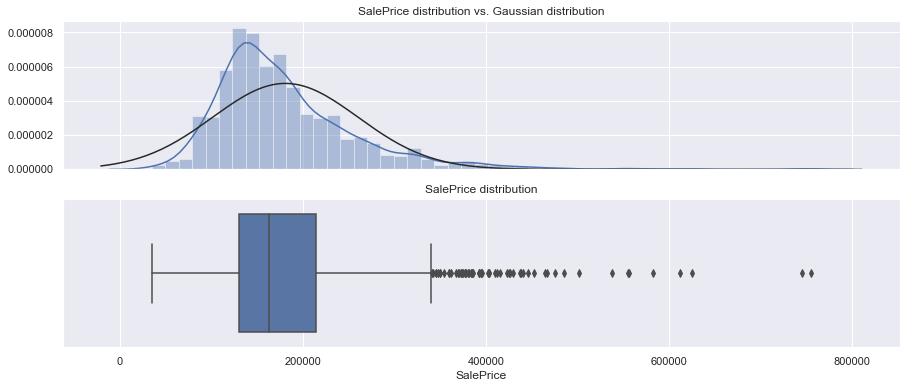

In [33]:
num_univariate(house_prices, 'SalePrice')

As a result of having many outliers, SalePrice has a non-Normal distribution. It is skewed to the right (skewness=1.88), quite tail-heavy (kurtosis=6.54), and quite leptokurtic (more peaked than the Normal distribution). The plot below shows what the distribution of SalePrice would look like if it were log-transformed.

<Figure size 1080x216 with 0 Axes>

Text(0.5, 1.0, 'Log-transformed SalePrice distribution vs. Gaussian distribution')

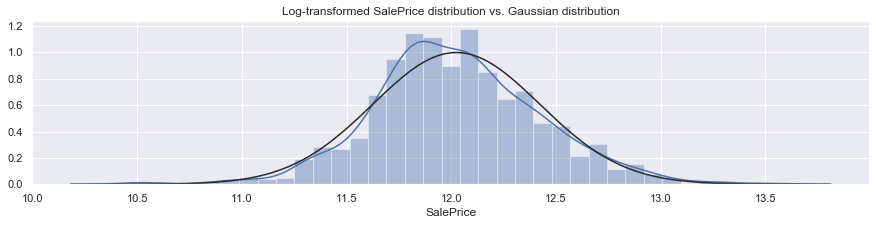

In [34]:
plt.figure(figsize=(15,3))
sns.distplot(np.log1p(house_prices['SalePrice']), fit=norm)
plt.title('Log-transformed SalePrice distribution vs. Gaussian distribution')

### Numerical (and Ordinal Categorical) Feature Analysis

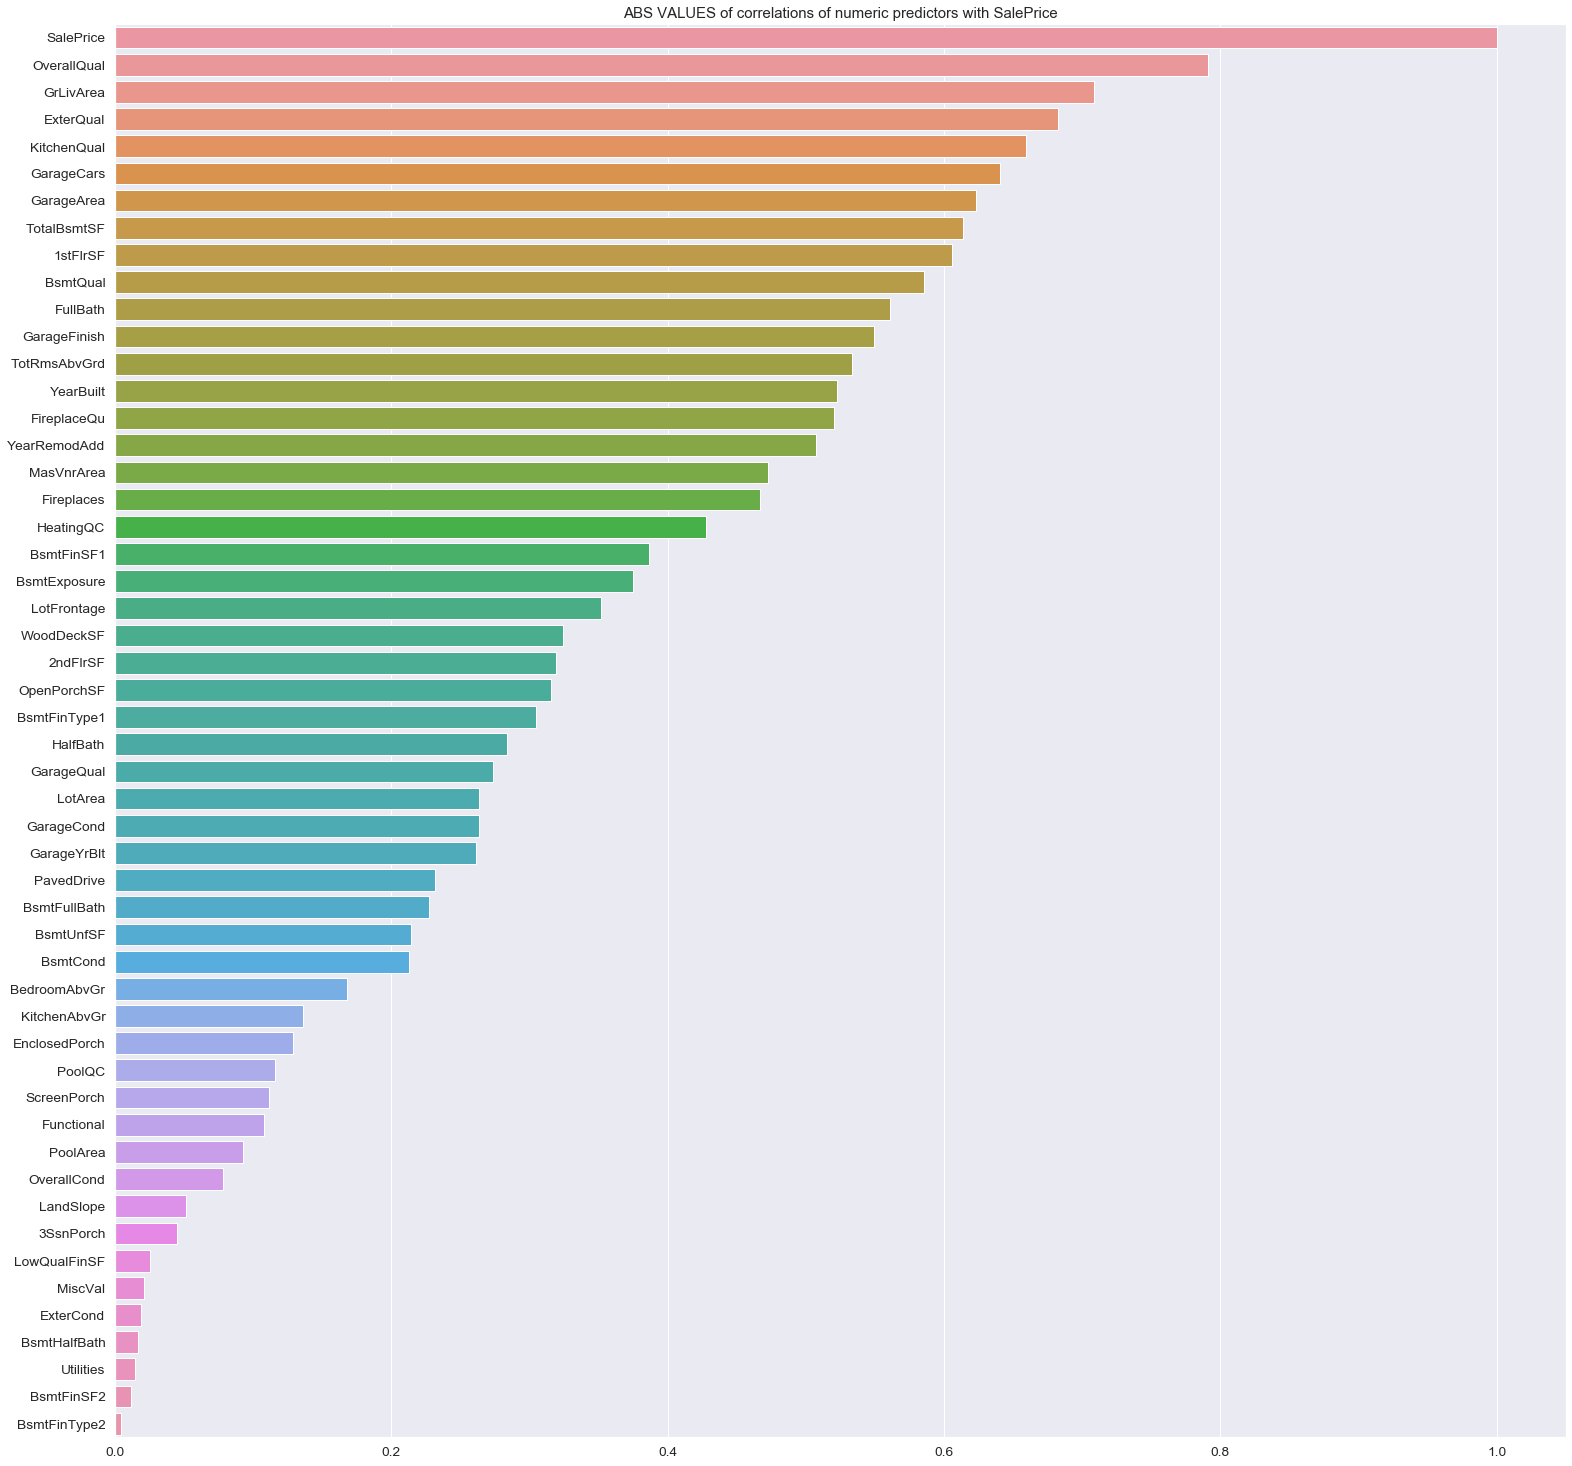

In [35]:
plot_corr_barplot(house_prices, num_feats, 'SalePrice', abs_val=1)

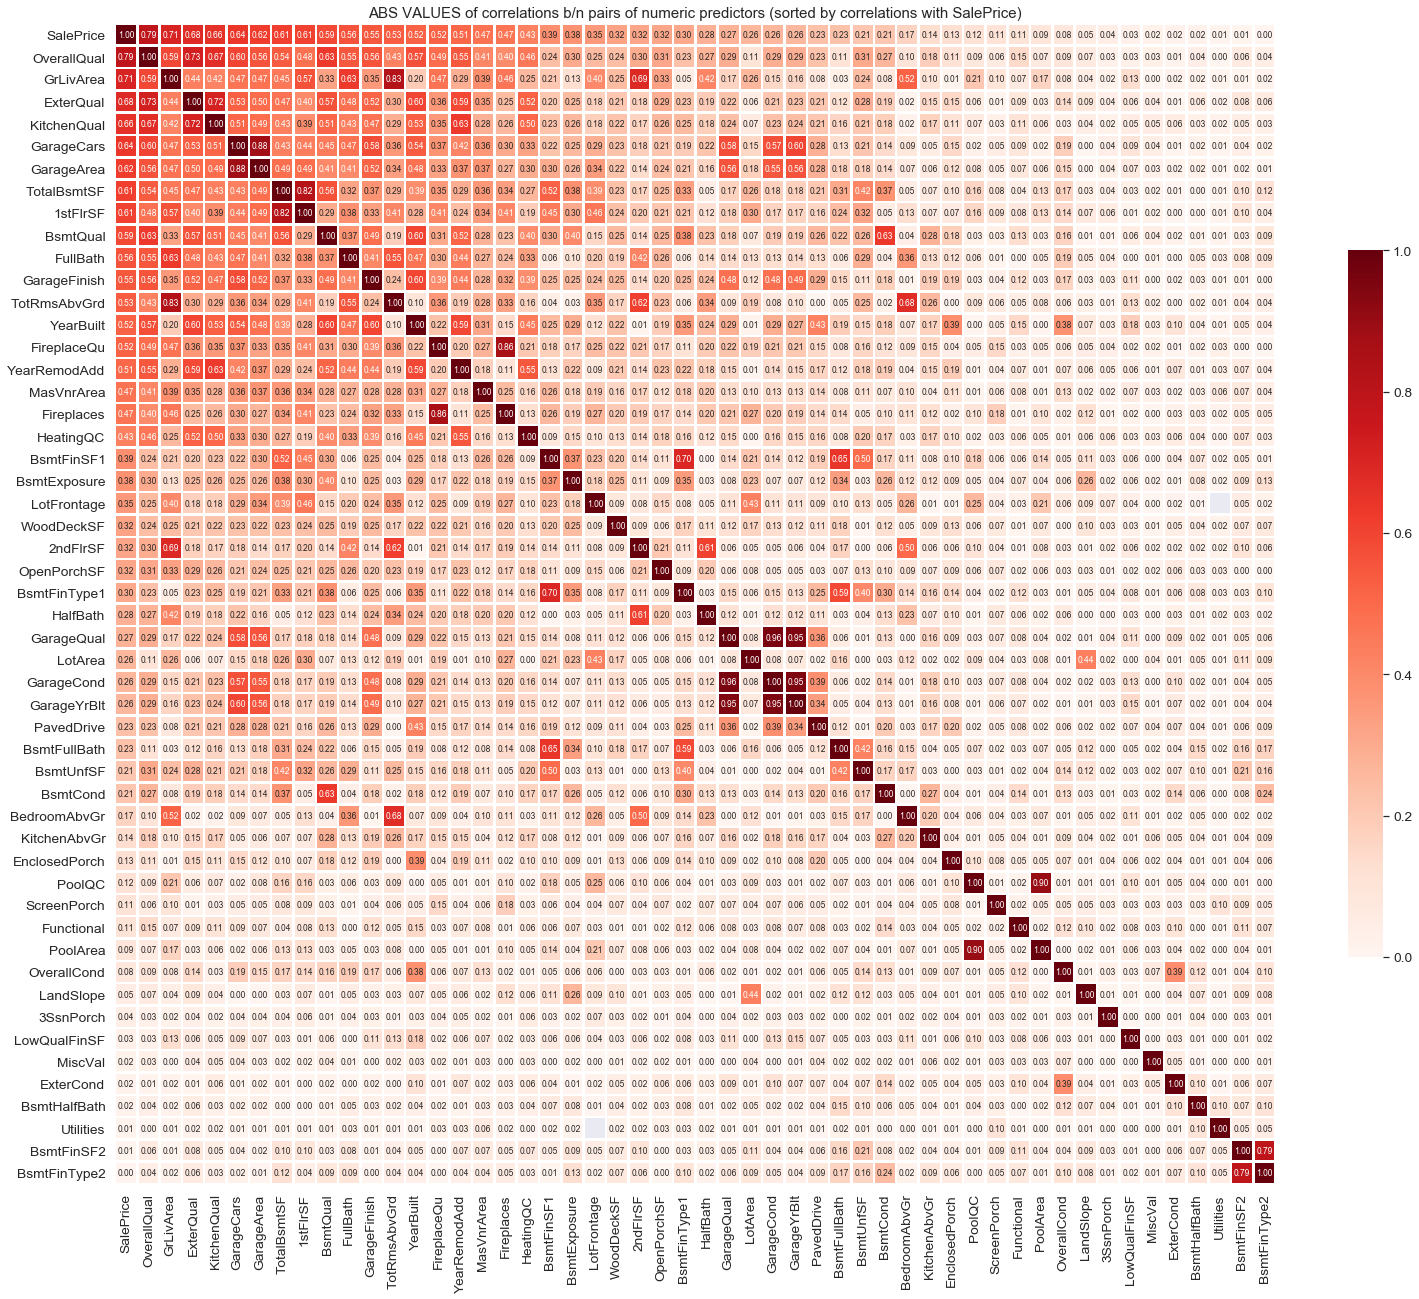

In [36]:
plot_corr_matrix(house_prices, num_feats, 'SalePrice', abs_val=1)

Now, let's take a look at a few numerical features that have very high correlations with SalePrice: OverallQual, GrLivArea, GarageArea, 1stFlrSF, FullBath. Notice that we are not looking at several features that have higher correlation with SalePrice than some of the above five. This is because they are very highly correlated with some of these five features. Hence, visualizing them is not going to provide a lot of extra value to us. For instance, GarageCars and TotalBsmtSF are very highly correlated with SalePrice, but they are also very highly correlated with GarageArea and 1stFlrSF, respectively.

OverallQual
Number of unique values        10.00
Minimum                         1.00
Maximum                        10.00
Range                           9.00
Skewness                        0.22
Kurtosis                        0.10

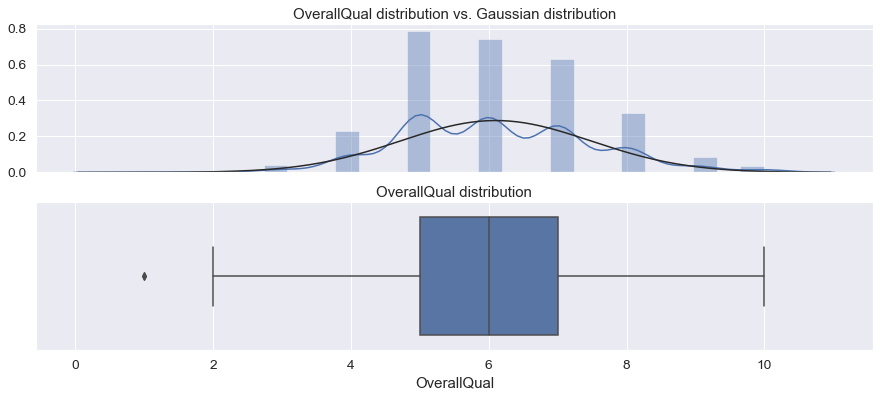

In [37]:
num_univariate(house_prices, 'OverallQual')

<Figure size 1080x432 with 0 Axes>

Text(0.5, 1.0, 'Distributions and counts of SalePrice by categories of OverallQual')

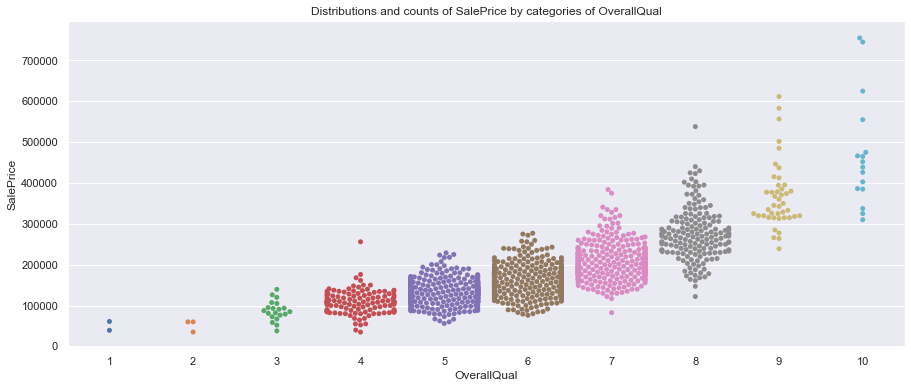

In [171]:
plt.figure(figsize=(15,6))
sns.swarmplot('OverallQual', 'SalePrice', data=house_prices)
plt.title('Distributions and counts of SalePrice by categories of OverallQual')

GrLivArea
Number of unique values     861.00
Minimum                     334.00
Maximum                    5642.00
Range                      5308.00
Skewness                      1.37
Kurtosis                      4.90

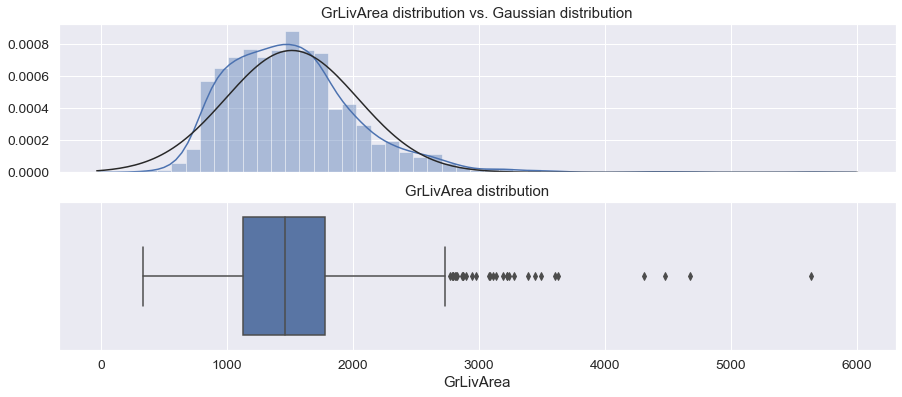

In [39]:
num_univariate(house_prices, 'GrLivArea')

<Figure size 648x432 with 0 Axes>

Text(0.5, 1.0, 'GrLivArea vs. SalePrice scatterlot')

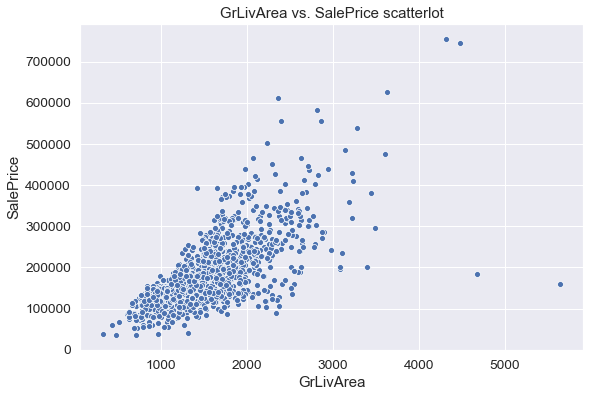

In [40]:
plt.figure(figsize=(9,6))
sns.scatterplot('GrLivArea', 'SalePrice', data=house_prices)
plt.title('GrLivArea vs. SalePrice scatterlot')

There are two blatant outliers in the bottom right corner of the above scatter plot. They are very far from the general trend. With their GrLivArea's being around 4,650 and 5,700 sqft, their SalePrice's should be about 4.5 times higher than they actually are. In order to avoid "confusing" the model and to improve performance, let's remove them.

In [41]:
drop_index = house_prices[house_prices.GrLivArea > 4500].index
house_prices.drop(drop_index, axis=0, inplace=True)

GarageArea
Number of unique values      440.00
Minimum                        0.00
Maximum                     1390.00
Range                       1390.00
Skewness                       0.13
Kurtosis                       0.76

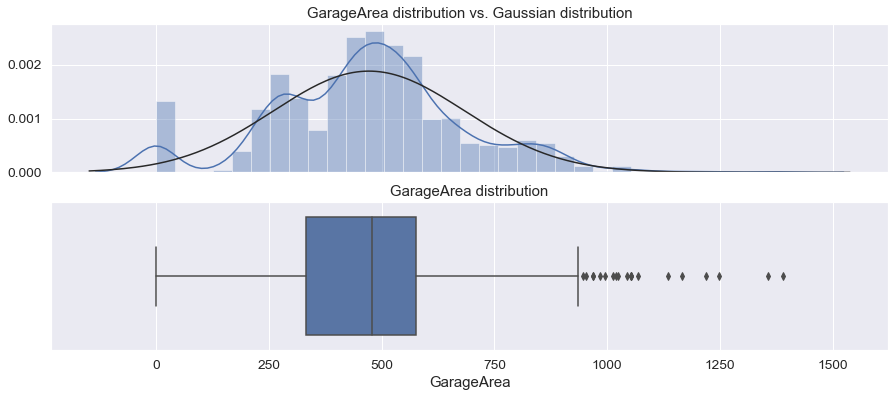

In [42]:
num_univariate(house_prices, 'GarageArea')

<Figure size 648x432 with 0 Axes>

Text(0.5, 1.0, 'GarageArea vs. SalePrice scatterlot')

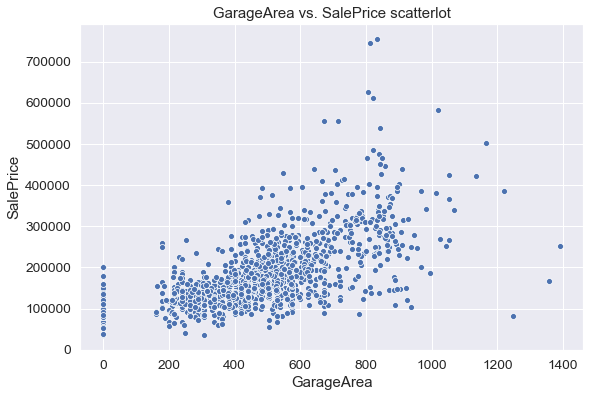

In [43]:
plt.figure(figsize=(9,6))
sns.scatterplot('GarageArea', 'SalePrice', data=house_prices)
plt.title('GarageArea vs. SalePrice scatterlot')

1stFlrSF
Number of unique values    751.00
Minimum                    334.00
Maximum                   3228.00
Range                     2894.00
Skewness                     0.89
Kurtosis                     1.12

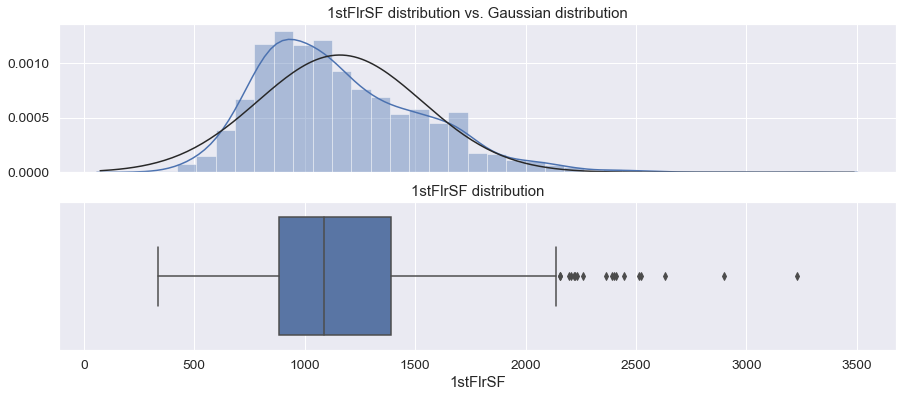

In [44]:
num_univariate(house_prices, '1stFlrSF')

<Figure size 648x432 with 0 Axes>

Text(0.5, 1.0, '1stFlrSF vs. SalePrice scatterlot')

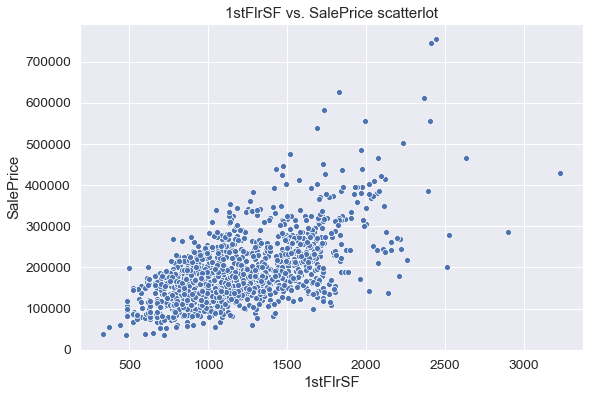

In [45]:
plt.figure(figsize=(9,6))
sns.scatterplot('1stFlrSF', 'SalePrice', data=house_prices)
plt.title('1stFlrSF vs. SalePrice scatterlot')

FullBath
Number of unique values      4.00
Minimum                      0.00
Maximum                      3.00
Range                        3.00
Skewness                     0.03
Kurtosis                    -0.87

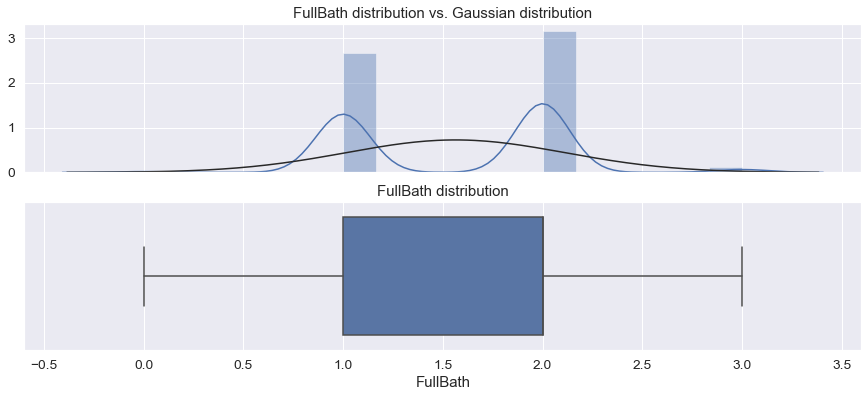

In [46]:
num_univariate(house_prices, 'FullBath')

<Figure size 1080x432 with 0 Axes>

Text(0.5, 1.0, 'Distributions and counts of SalePrice by categories of FullBath')

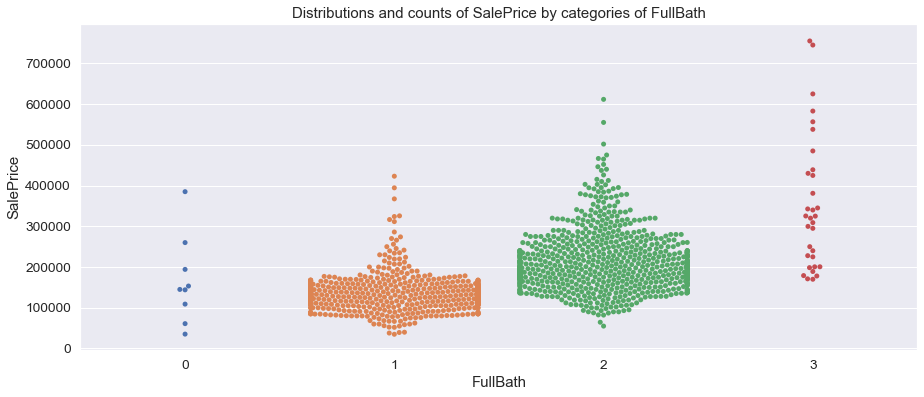

In [47]:
plt.figure(figsize=(15,6))
sns.swarmplot('FullBath', 'SalePrice', data=house_prices)
plt.title('Distributions and counts of SalePrice by categories of FullBath')

### Nominal Categorical Feature Analysis

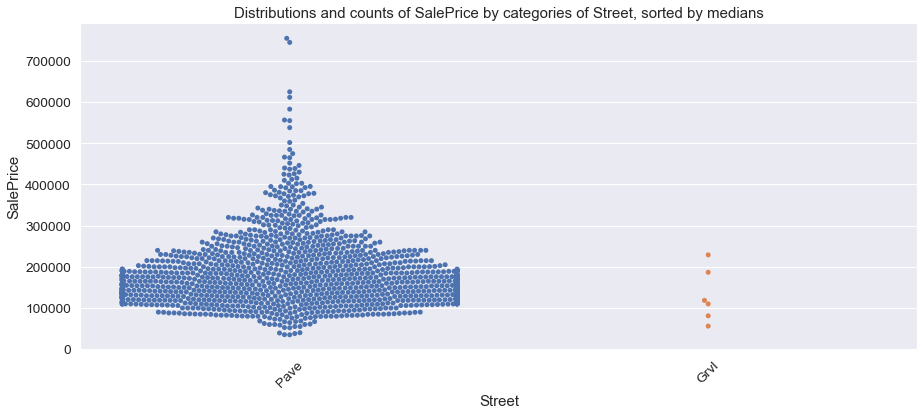

In [48]:
cat_bivariate(house_prices, 'Street', 'SalePrice', 'swarm')

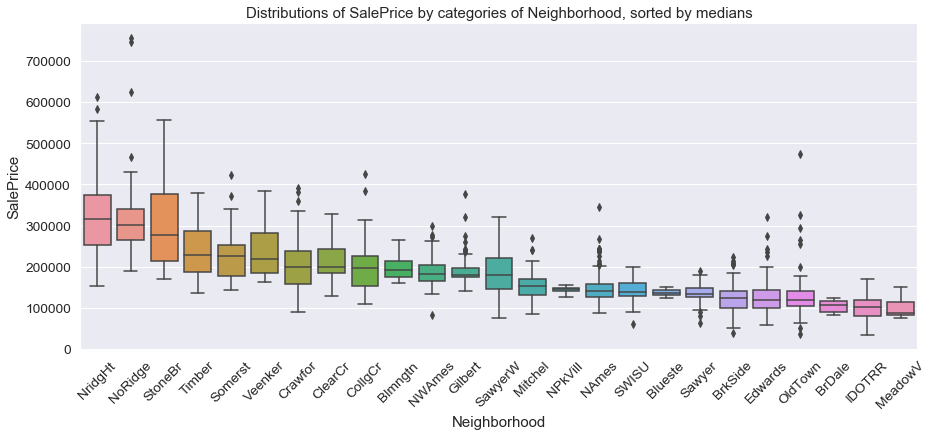

In [49]:
cat_bivariate(house_prices, 'Neighborhood', 'SalePrice', 'box')

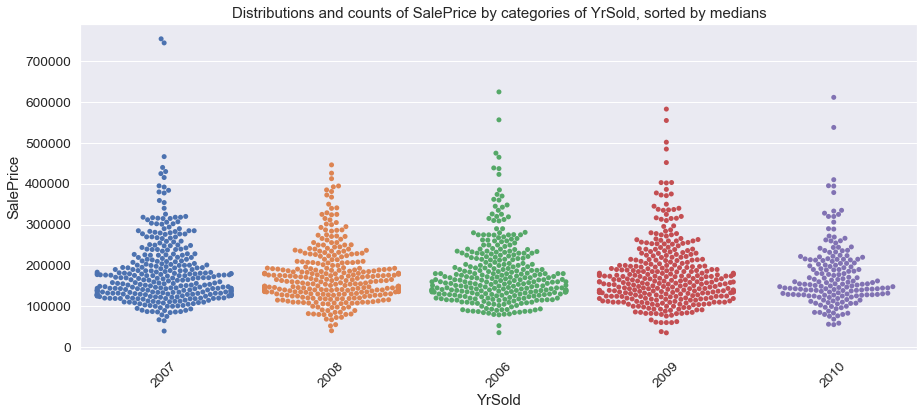

In [50]:
cat_bivariate(house_prices, 'YrSold', 'SalePrice', 'swarm')

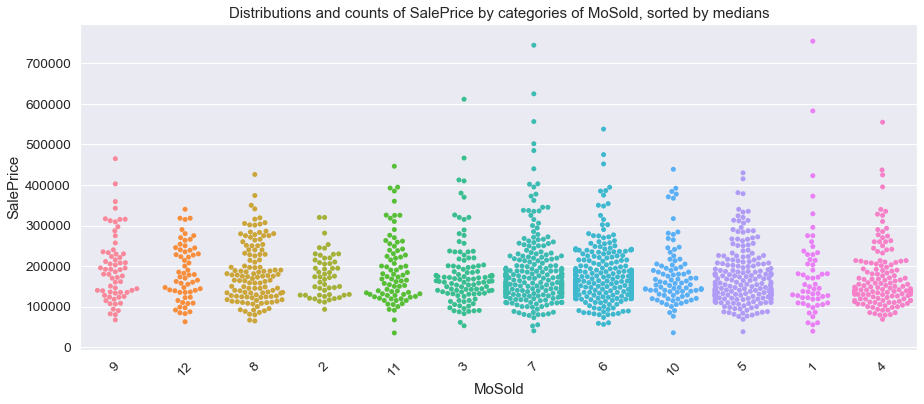

In [51]:
cat_bivariate(house_prices, 'MoSold', 'SalePrice', 'swarm')

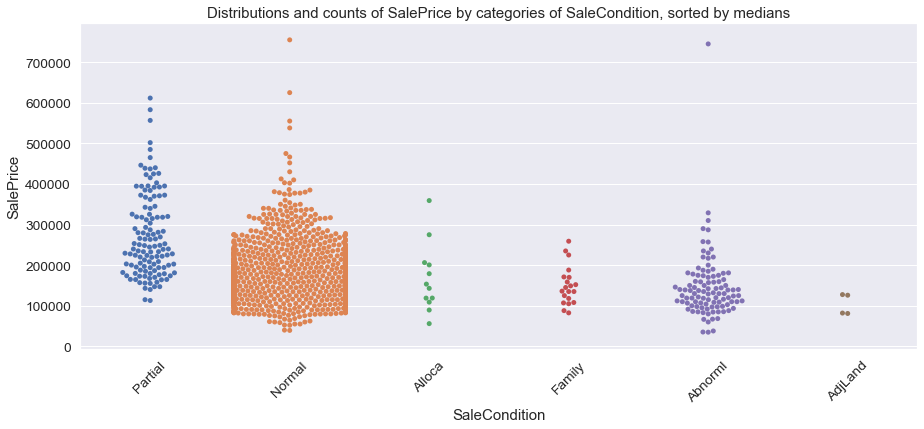

In [52]:
cat_bivariate(house_prices, 'SaleCondition', 'SalePrice', 'swarm')

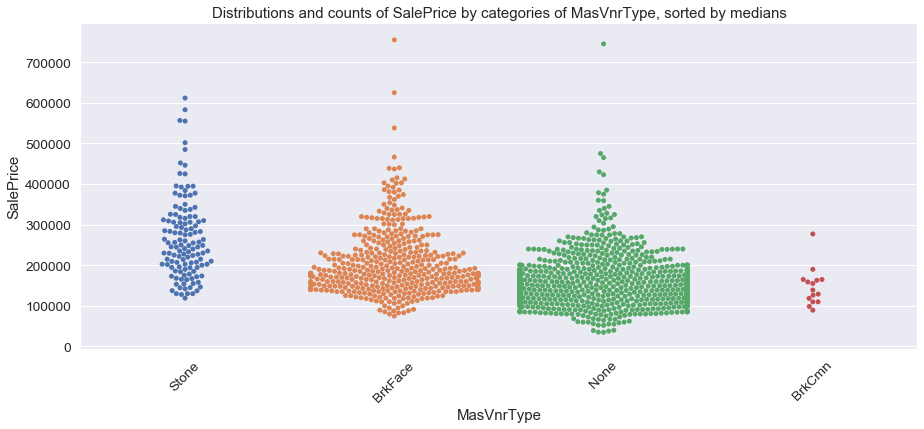

In [53]:
cat_bivariate(house_prices, 'MasVnrType', 'SalePrice', 'swarm')

# Engineer Features

In [54]:
# X is house_prices without SalePrice column
X = house_prices.drop('SalePrice', axis=1)
y = house_prices.SalePrice

# divide (X, y) into (X_train, y_train) and (X_test, y_test)
# (X_train, y_train) will be used to tune hyper-parameters of models
# (X_test, y_test) will be used to calculate the test error (i.e. to approximate generalization error)
# (X, y), which is all available ground truth data, will be used at the very end to fit the stack (with optimal
# hyper-parameters); this final model wil be use to make predictions on the predict dataset for submission
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [55]:
# create new features
datasets = [X_train, X_test, X, predict]
for df in datasets:
    # AREA-RELATED
    # numerical / numerical combinations
    df['InsideSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['PorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
    df['TotalSF'] = df['InsideSF'] + df['PorchSF'] + df['WoodDeckSF'] + df['GarageArea']
    df['FrctnBsmtFinished'] = (df['BsmtFinSF1'] + df['BsmtFinSF2']) / df['TotalBsmtSF']
    df['GrLivArea_per_InsideSF'] = df['GrLivArea'] / df['InsideSF']
    df['BedroomAbvGr_per_TotRmsAbvGrd'] = df['BedroomAbvGr'] / df['TotRmsAbvGrd']
    df['KitchenAbvGr_per_TotRmsAbvGrd'] = df['KitchenAbvGr'] / df['TotRmsAbvGrd']
    df['BsmtBath'] = df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']
    df['BathAbvGr'] = df['FullBath'] + 0.5*df['HalfBath']
    df['BathAbvGr_per_TotRmsAbvGrd'] = df['BathAbvGr'] / df['TotRmsAbvGrd']
    # ------------------------------------------------------------------------------------------
    # TIME-RELATED
    # numerical / numerical combinations
    df['YrsSinceRemodel'] = df['YrSold'].astype('int64') - df['YearRemodAdd']
    df['Age'] = df['YrSold'].astype('int64') - df['YearBuilt']
    # categorical / categorical combinations
    df['YrSold__MoSold'] = df['YrSold'].astype('str') + '/' + df['MoSold'].astype('str')
    # ------------------------------------------------------------------------------------------
    # QUALITY-RELATED
    # numerical / numerical combinations
    # quality * condition
    df['HouseTotalQuality'] = df['OverallQual'] * df['OverallCond']
    df['ExterTotalQuality'] = df['ExterQual'] * df['ExterCond']
    df['BsmtTotalQuality'] = df['BsmtQual'] * df['BsmtCond']
    df['GarageTotalQuality'] = df['GarageQual'] * df['GarageCond']
    # quality * area/quantity
    df['HouseTotalQuality__TotalSF'] = df['HouseTotalQuality'] * df['TotalSF']
    df['HouseTotalQuality__InsideSF'] = df['HouseTotalQuality'] * df['InsideSF']
    df['PoolQC__PoolArea'] = df['PoolQC'] * df['PoolArea']
    df['FireplaceQu__Fireplaces'] = df['FireplaceQu'] * df['Fireplaces']
    df['BsmtFinType1__BsmtFinSF1'] = df['BsmtFinType1'] * df['BsmtFinSF1']
    df['BsmtFinType2__BsmtFinSF2'] = df['BsmtFinType2'] * df['BsmtFinSF2']
    # ------------------------------------------------------------------------------------------

# AREA-RELATED
# nominal categorical / numerical combinations
nom__num(X_train, [X_test, X, predict,], 'MSZoning', 'TotalSF')
nom__num(X_train, [X_test, X, predict,], 'Neighborhood', 'TotalSF')
nom__num(X_train, [X_test, X, predict,], 'MSZoning', 'LotArea')
nom__num(X_train, [X_test, X, predict,], 'Neighborhood', 'LotArea')
# QUALITY-RELATED
# quality * area/quantity
# nominal categorical / numerical combinations
nom__num(X_train, [X_test, X, predict,], 'MSZoning', 'HouseTotalQuality')
nom__num(X_train, [X_test, X, predict,], 'Neighborhood', 'HouseTotalQuality')
nom__num(X_train, [X_test, X, predict,], 'Heating', 'HeatingQC')
nom__num(X_train, [X_test, X, predict,], 'MasVnrType', 'MasVnrArea')

# Preprocess Data (create preprocessing pipelines)

Now, we will create two pre-processing pipelines: one for numerical features and one for nominal categorical features.

Step 1 of both of these pipelines will perform missing value imputation (using scikit-learn's SimpleImputer) –– with the median for numerical features and the mode for nominal categorical features.

Step 2 of the numerical pipeline will deal with the issues revealed by the statistical summaries and plots above. In particular, the previous section has demonstrated that our numerical features are on vastly different scales and that many of them have non-Gaussian distributions. Because many models perform a lot better when features are on a similar scale and when features have a roughly Normal distribution, we will perform feature scaling and a power transformation. Feature scaling will be performed using scikit-learn's RobustScaler, which scales features using statistics (the IQR) that are robust to outliers. We have already gotten rid of the largest outliers manually. Rather than deleting the smaller outliers (which is undesirable) or replacing their values with something, we will significantly reduce their effect on our models' performance using the RobustScaler. The power transformation (Yeo-Johnson) will be performed using scikit-learn's PowerTransformer.

Step 2 of the nominal categorical pipeline will consist of one-hot encoding the features using scikit-learn's OneHotEncoder.

For extra convenience down the road, these two pipelines will be joined into a single pre-processing pipeline.

Finally, as we have also seen in the previous section, the target (SalePrice) will benefit from being power-transformed. For ease of interpretation and reversing the transformation for submission at the end of the project, we will perform the transformation using numpy.log1p rather than PowerTransformer.

In [56]:
# create a list of all numerical features and a list of all nominal categorical features
# these lists will specify what transformations are to be performed on what columns
all_num_feats = X_train.select_dtypes(include='number').columns.tolist()
all_nom_feats = X_train.select_dtypes(include='object').columns.tolist()

# create preprocessing pipelines for numerical features and for nominal categorical features and combine them into a
# single preprocessing pipeline
num_pipe = make_pipeline(SimpleImputer(strategy='median'), RobustScaler(), PowerTransformer(standardize=False))
nom_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'))
prep_pipe = make_column_transformer((num_pipe, all_num_feats), (nom_pipe, all_nom_feats), remainder='passthrough', sparse_threshold=0)

# log-transform SalePrice in y_train, y_test, and y (which consists of the former two)
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)
y = np.log1p(y)

# Choose and Train Models

In [57]:
# create cross-validation folds to be used to tune hyper-parameters of all models and create out-of-bag predictions
# that the final model of the stack will be tuned on; this way, if we need to later compare the performance of
# individual models, we can do so on the exact same data
cv = KFold(n_splits=10, shuffle=True, random_state=0)

## Level-1 Models

In [58]:
# tune k-Nearest Neighbors hyper-parameters
def knn_objective(trial):
    params = {'n_neighbors': trial.suggest_int('n_neighbors', 1, 30),
              'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
              'p': trial.suggest_int('p', 1, 2)}
    full_pipe = make_pipeline(prep_pipe, KNeighborsRegressor(**params))
    scores = cross_val_score(full_pipe, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    return np.sqrt(np.mean(-scores))    # return mean cross-validation test RMSLE (Root Mean Squared Logarithmic Error) score

knn_study = optuna.create_study(direction='minimize')
knn_study.optimize(knn_objective, n_trials=100)
joblib.dump(knn_study, 'knn_study.pkl')

knn_study_df = knn_study.trials_dataframe(attrs=['value', "params", "user_attrs", "system_attrs"])
rename_columns(knn_study_df)

[I 2020-05-24 20:20:47,040] Finished trial#0 with value: 0.15326113938314684 with parameters: {'n_neighbors': 14, 'weights': 'distance', 'p': 2}. Best is trial#0 with value: 0.15326113938314684.
[I 2020-05-24 20:20:50,348] Finished trial#1 with value: 0.158785721088044 with parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 2}. Best is trial#0 with value: 0.15326113938314684.
[I 2020-05-24 20:20:53,646] Finished trial#2 with value: 0.1609334467836427 with parameters: {'n_neighbors': 29, 'weights': 'uniform', 'p': 2}. Best is trial#0 with value: 0.15326113938314684.
[I 2020-05-24 20:20:56,969] Finished trial#3 with value: 0.1545390994303073 with parameters: {'n_neighbors': 17, 'weights': 'distance', 'p': 2}. Best is trial#0 with value: 0.15326113938314684.
[I 2020-05-24 20:21:01,100] Finished trial#4 with value: 0.15031430991248781 with parameters: {'n_neighbors': 3, 'weights': 'uniform', 'p': 2}. Best is trial#4 with value: 0.15031430991248781.
[I 2020-05-24 20:21:04,569] Finis

[I 2020-05-24 20:25:10,977] Finished trial#42 with value: 0.14911767205491752 with parameters: {'n_neighbors': 7, 'weights': 'uniform', 'p': 2}. Best is trial#7 with value: 0.14734903231490842.
[I 2020-05-24 20:25:18,803] Finished trial#43 with value: 0.1486603871545484 with parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 2}. Best is trial#7 with value: 0.14734903231490842.
[I 2020-05-24 20:25:24,693] Finished trial#44 with value: 0.15031430991248781 with parameters: {'n_neighbors': 3, 'weights': 'uniform', 'p': 2}. Best is trial#7 with value: 0.14734903231490842.
[I 2020-05-24 20:25:30,303] Finished trial#45 with value: 0.1491303415500072 with parameters: {'n_neighbors': 8, 'weights': 'uniform', 'p': 2}. Best is trial#7 with value: 0.14734903231490842.
[I 2020-05-24 20:25:36,153] Finished trial#46 with value: 0.15184925273028588 with parameters: {'n_neighbors': 10, 'weights': 'uniform', 'p': 2}. Best is trial#7 with value: 0.14734903231490842.
[I 2020-05-24 20:25:42,302] Fin

[I 2020-05-24 20:29:06,236] Finished trial#84 with value: 0.14927187618845533 with parameters: {'n_neighbors': 4, 'weights': 'distance', 'p': 2}. Best is trial#7 with value: 0.14734903231490842.
[I 2020-05-24 20:29:12,939] Finished trial#85 with value: 0.14979666000905464 with parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 2}. Best is trial#7 with value: 0.14734903231490842.
[I 2020-05-24 20:29:18,456] Finished trial#86 with value: 0.14762264524612198 with parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 2}. Best is trial#7 with value: 0.14734903231490842.
[I 2020-05-24 20:29:23,217] Finished trial#87 with value: 0.16430404826450276 with parameters: {'n_neighbors': 2, 'weights': 'distance', 'p': 2}. Best is trial#7 with value: 0.14734903231490842.
[I 2020-05-24 20:29:27,972] Finished trial#88 with value: 0.14927187618845533 with parameters: {'n_neighbors': 4, 'weights': 'distance', 'p': 2}. Best is trial#7 with value: 0.14734903231490842.
[I 2020-05-24 20:29:32,18

['knn_study.pkl']

In [169]:
# best RMSLE score and corresponding hyper-parameters of k-Nearest Neighbors
knn_study.best_value
knn_study.best_params
optuna.visualization.plot_slice(knn_study)

0.14734903231490842

{'n_neighbors': 6, 'weights': 'distance', 'p': 2}

value  n_neighbors  p   weights
7  0.147349            6  2  distance

[{'n_neighbors': 6, 'p': 2, 'weights': 'distance'}]

<Figure size 1080x432 with 0 Axes>

(0.1, 0.2)

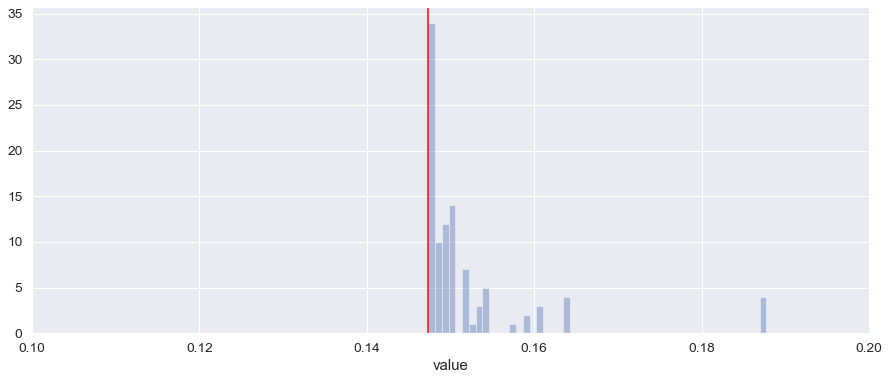

In [77]:
PT = .02
knn_study_df[knn_study_df.value == knn_study_df.value.quantile(PT, interpolation='higher')].nsmallest(1, 'value', keep='first')
knn_study_df[knn_study_df.value == knn_study_df.value.quantile(PT, interpolation='higher')].nsmallest(1, 'value', keep='first').drop('value', axis=1).to_dict(orient='records')

plt.figure(figsize=(15,6))
sns.distplot(knn_study_df.value, bins=50, kde=False)
plt.axvline(knn_study_df.value.quantile(PT, interpolation='higher'), color='red')
plt.xlim(.1,.2)

In [71]:
knn_best_score = 0.147349
knn_best_params = {'n_neighbors': 6, 'p': 2, 'weights': 'distance'}

In [79]:
# tune Support Vector Machine hyper-parameters
def svr_objective(trial):
    params = {'kernel': trial.suggest_categorical('kernel', ['rbf', 'sigmoid']),
              'gamma': trial.suggest_loguniform('gamma', 1e-10, 100),
              'C': trial.suggest_loguniform('C', 1e-10, 1e5)}
    
    full_pipe = make_pipeline(prep_pipe, SVR(**params))
    scores = cross_val_score(full_pipe, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
   
    return np.sqrt(np.mean(-scores))    # return mean cross-validation test RMSLE (Root Mean Squared Logarithmic Error) score

svr_study = optuna.create_study(direction='minimize')
svr_study.optimize(svr_objective, n_trials=250)
joblib.dump(svr_study, 'svr_study.pkl')

svr_study_df = svr_study.trials_dataframe(attrs=['value', "params", "user_attrs", "system_attrs"])
rename_columns(svr_study_df)

[I 2020-05-24 20:43:11,972] Finished trial#0 with value: 0.3929871586380239 with parameters: {'kernel': 'rbf', 'gamma': 6.882909327125109e-07, 'C': 5.105712530006397e-10}. Best is trial#0 with value: 0.3929871586380239.
[I 2020-05-24 20:43:19,466] Finished trial#1 with value: 4221.481315177409 with parameters: {'kernel': 'sigmoid', 'gamma': 4.137934725414016, 'C': 36.429903498717714}. Best is trial#0 with value: 0.3929871586380239.
[I 2020-05-24 20:43:26,250] Finished trial#2 with value: 9.854619119169062 with parameters: {'kernel': 'sigmoid', 'gamma': 0.028004287757901355, 'C': 0.533681489868498}. Best is trial#0 with value: 0.3929871586380239.
[I 2020-05-24 20:43:33,112] Finished trial#3 with value: 0.3929871585281728 with parameters: {'kernel': 'rbf', 'gamma': 3.585030702640892e-06, 'C': 2.3580056789193663e-09}. Best is trial#3 with value: 0.3929871585281728.
[I 2020-05-24 20:43:39,905] Finished trial#4 with value: 0.39298715789828736 with parameters: {'kernel': 'rbf', 'gamma': 2.66

[I 2020-05-24 20:47:51,951] Finished trial#37 with value: 0.3798352763005814 with parameters: {'kernel': 'rbf', 'gamma': 0.011171048186852847, 'C': 0.00028573643597964207}. Best is trial#32 with value: 0.12877028673303106.
[I 2020-05-24 20:48:01,003] Finished trial#38 with value: 0.3929869359147398 with parameters: {'kernel': 'rbf', 'gamma': 1.4223354616358441e-05, 'C': 1.1563483780562066e-06}. Best is trial#32 with value: 0.12877028673303106.
[I 2020-05-24 20:48:09,524] Finished trial#39 with value: 0.3933076077493428 with parameters: {'kernel': 'sigmoid', 'gamma': 2.467943314448369e-06, 'C': 0.018283550082562935}. Best is trial#32 with value: 0.12877028673303106.
[I 2020-05-24 20:48:16,733] Finished trial#40 with value: 0.13563236045532773 with parameters: {'kernel': 'rbf', 'gamma': 0.00018845566344486336, 'C': 1.0726725521265152}. Best is trial#32 with value: 0.12877028673303106.
[I 2020-05-24 20:48:24,460] Finished trial#41 with value: 0.13551737904000574 with parameters: {'kernel'

[I 2020-05-24 20:52:46,657] Finished trial#74 with value: 0.128776854562038 with parameters: {'kernel': 'rbf', 'gamma': 0.005617782842430284, 'C': 0.6324837802032343}. Best is trial#73 with value: 0.1286908642683875.
[I 2020-05-24 20:52:51,668] Finished trial#75 with value: 0.12893728081178854 with parameters: {'kernel': 'rbf', 'gamma': 0.0040083251571880725, 'C': 0.5134037239511342}. Best is trial#73 with value: 0.1286908642683875.
[I 2020-05-24 20:52:57,562] Finished trial#76 with value: 0.282464349005197 with parameters: {'kernel': 'rbf', 'gamma': 0.0041461344743775625, 'C': 0.003852954798621005}. Best is trial#73 with value: 0.1286908642683875.
[I 2020-05-24 20:53:04,008] Finished trial#77 with value: 0.39074407305155673 with parameters: {'kernel': 'rbf', 'gamma': 0.26385487569364907, 'C': 0.05116389873400297}. Best is trial#73 with value: 0.1286908642683875.
[I 2020-05-24 20:53:09,459] Finished trial#78 with value: 0.23308325447752662 with parameters: {'kernel': 'rbf', 'gamma': 0.

[I 2020-05-24 20:55:56,559] Finished trial#111 with value: 0.12991249790768142 with parameters: {'kernel': 'rbf', 'gamma': 0.0022353203330074557, 'C': 0.8026866431717574}. Best is trial#88 with value: 0.12809256275403055.
[I 2020-05-24 20:56:00,674] Finished trial#112 with value: 0.1351407000913766 with parameters: {'kernel': 'rbf', 'gamma': 0.012554447036652355, 'C': 1.2405424848169413}. Best is trial#88 with value: 0.12809256275403055.
[I 2020-05-24 20:56:04,925] Finished trial#113 with value: 0.15602340476680965 with parameters: {'kernel': 'rbf', 'gamma': 0.0008204007607528792, 'C': 0.0816889639975692}. Best is trial#88 with value: 0.12809256275403055.
[I 2020-05-24 20:56:09,151] Finished trial#114 with value: 0.132936800498798 with parameters: {'kernel': 'rbf', 'gamma': 0.002303995045930455, 'C': 7.508630485272041}. Best is trial#88 with value: 0.12809256275403055.
[I 2020-05-24 20:56:13,417] Finished trial#115 with value: 0.13969175540435538 with parameters: {'kernel': 'rbf', 'gam

[I 2020-05-24 21:00:38,711] Finished trial#148 with value: 0.19011047401790085 with parameters: {'kernel': 'rbf', 'gamma': 0.028010232203358888, 'C': 0.0612046262379729}. Best is trial#141 with value: 0.12802870056911886.
[I 2020-05-24 21:00:46,261] Finished trial#149 with value: 0.39297411636850005 with parameters: {'kernel': 'rbf', 'gamma': 0.012217263720301826, 'C': 2.784204149630008e-07}. Best is trial#141 with value: 0.12802870056911886.
[I 2020-05-24 21:00:52,110] Finished trial#150 with value: 0.13481457703069893 with parameters: {'kernel': 'rbf', 'gamma': 0.0009096344858247427, 'C': 0.2946102219573158}. Best is trial#141 with value: 0.12802870056911886.
[I 2020-05-24 21:00:56,753] Finished trial#151 with value: 0.12822296852160284 with parameters: {'kernel': 'rbf', 'gamma': 0.004752667115265499, 'C': 0.9292231342893399}. Best is trial#141 with value: 0.12802870056911886.
[I 2020-05-24 21:01:01,152] Finished trial#152 with value: 0.1281529586697629 with parameters: {'kernel': 'r

[I 2020-05-24 21:05:22,678] Finished trial#184 with value: 0.1321906872048511 with parameters: {'kernel': 'rbf', 'gamma': 0.001073687554905975, 'C': 0.8614783643803365}. Best is trial#141 with value: 0.12802870056911886.
[I 2020-05-24 21:05:31,558] Finished trial#185 with value: 0.13462190980345715 with parameters: {'kernel': 'rbf', 'gamma': 0.010906780213988599, 'C': 2.03849396605472}. Best is trial#141 with value: 0.12802870056911886.
[I 2020-05-24 21:05:37,694] Finished trial#186 with value: 0.1311359735834231 with parameters: {'kernel': 'rbf', 'gamma': 0.002342564218549442, 'C': 0.4836643023275026}. Best is trial#141 with value: 0.12802870056911886.
[I 2020-05-24 21:05:48,198] Finished trial#187 with value: 0.13528868940525524 with parameters: {'kernel': 'rbf', 'gamma': 0.004698357426181295, 'C': 0.17949089379770694}. Best is trial#141 with value: 0.12802870056911886.
[I 2020-05-24 21:05:57,902] Finished trial#188 with value: 0.13472452791196915 with parameters: {'kernel': 'rbf', '

[I 2020-05-24 21:09:53,881] Finished trial#220 with value: 0.13111181867163624 with parameters: {'kernel': 'rbf', 'gamma': 0.00317247410204939, 'C': 5.089008712856078}. Best is trial#141 with value: 0.12802870056911886.
[I 2020-05-24 21:09:58,008] Finished trial#221 with value: 0.12894291888545398 with parameters: {'kernel': 'rbf', 'gamma': 0.002267070810644203, 'C': 1.4673083267212115}. Best is trial#141 with value: 0.12802870056911886.
[I 2020-05-24 21:10:01,827] Finished trial#222 with value: 0.1290245887845809 with parameters: {'kernel': 'rbf', 'gamma': 0.004854222396216455, 'C': 0.4736247663460995}. Best is trial#141 with value: 0.12802870056911886.
[I 2020-05-24 21:10:05,712] Finished trial#223 with value: 0.1283284219800315 with parameters: {'kernel': 'rbf', 'gamma': 0.0033521572496886735, 'C': 1.4580983335909956}. Best is trial#141 with value: 0.12802870056911886.
[I 2020-05-24 21:10:10,576] Finished trial#224 with value: 0.12868235145766413 with parameters: {'kernel': 'rbf', '

['svr_study.pkl']

In [170]:
# best RMSLE score and corresponding hyper-parameters of Support Vector Machine
svr_study.best_value
svr_study.best_params
optuna.visualization.plot_slice(svr_study)

0.12802870056911886

{'kernel': 'rbf', 'gamma': 0.0036993091521479917, 'C': 0.8393338237010449}

value         C     gamma kernel
138  0.128142  1.109822  0.003681    rbf

[{'C': 1.109821617981156, 'gamma': 0.0036807550687435334, 'kernel': 'rbf'}]

<Figure size 1080x432 with 0 Axes>

(0.1, 0.2)

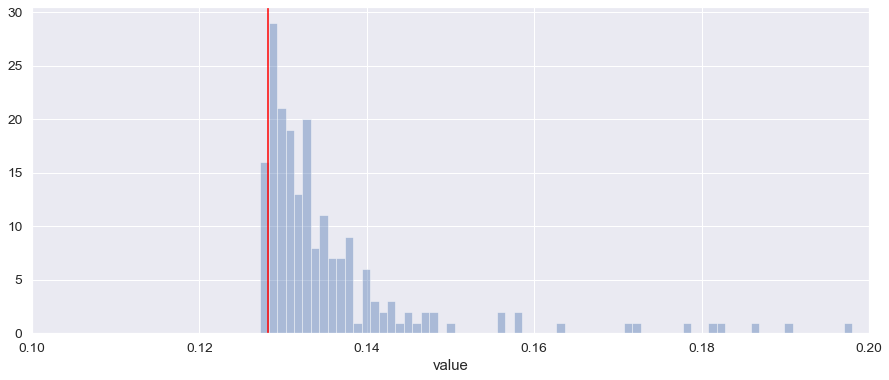

In [111]:
PT = .02
svr_study_df[svr_study_df.value == svr_study_df.value.quantile(PT, interpolation='higher')].nsmallest(1, 'value', keep='first')
svr_study_df[svr_study_df.value == svr_study_df.value.quantile(PT, interpolation='higher')].nsmallest(1, 'value', keep='first').drop('value', axis=1).to_dict(orient='records')

plt.figure(figsize=(15,6))
sns.distplot(svr_study_df.value, bins=np.linspace(.1,.2,100), kde=False)
plt.axvline(svr_study_df.value.quantile(PT, interpolation='higher'), color='red')
plt.xlim(.1,.2)

In [112]:
svr_best_score = 0.128142
svr_best_params = {'C': 1.109821617981156, 'gamma': 0.0036807550687435334, 'kernel': 'rbf'}

In [113]:
# tune Random Forest hyper-parameters
def rf_objective(trial):
    params = {'max_depth': trial.suggest_int('max_depth', 1, 200),
              'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 25, 1250),
              'min_samples_split': trial.suggest_int('min_samples_split', 2, 500),
              'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 250),
              'n_estimators': 50,                                                     # low value to make it run faster
              'max_samples': trial.suggest_uniform('max_samples', 0, 1),
              'max_features': trial.suggest_uniform('max_features', 0, 1)}
    
    full_pipe = make_pipeline(prep_pipe, RandomForestRegressor(**params))
    scores = cross_val_score(full_pipe, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
   
    return np.sqrt(np.mean(-scores))    # return mean cross-validation test RMSLE (Root Mean Squared Logarithmic Error) score

rf_study = optuna.create_study(direction='minimize')
rf_study.optimize(rf_objective, n_trials=250)
joblib.dump(rf_study, 'rf_study.pkl')

rf_study_df = rf_study.trials_dataframe(attrs=['value', "params", "user_attrs", "system_attrs"])
rename_columns(rf_study_df)

[I 2020-05-24 21:33:28,637] Finished trial#0 with value: 0.25581686862135344 with parameters: {'max_depth': 96, 'max_leaf_nodes': 134, 'min_samples_split': 233, 'min_samples_leaf': 105, 'max_samples': 0.360702233899839, 'max_features': 0.47064313933871627}. Best is trial#0 with value: 0.25581686862135344.
[I 2020-05-24 21:33:31,499] Finished trial#1 with value: 0.39200816188972093 with parameters: {'max_depth': 28, 'max_leaf_nodes': 662, 'min_samples_split': 326, 'min_samples_leaf': 154, 'max_samples': 0.22749543238460146, 'max_features': 0.6402696579124674}. Best is trial#0 with value: 0.25581686862135344.
[I 2020-05-24 21:33:34,766] Finished trial#2 with value: 0.25989257186181575 with parameters: {'max_depth': 153, 'max_leaf_nodes': 719, 'min_samples_split': 413, 'min_samples_leaf': 84, 'max_samples': 0.5830750840229013, 'max_features': 0.9655435547688227}. Best is trial#0 with value: 0.25581686862135344.
[I 2020-05-24 21:33:37,872] Finished trial#3 with value: 0.3923278136976901 wi

[I 2020-05-24 21:35:01,669] Finished trial#26 with value: 0.1890294372686929 with parameters: {'max_depth': 68, 'max_leaf_nodes': 344, 'min_samples_split': 2, 'min_samples_leaf': 76, 'max_samples': 0.73029968955168, 'max_features': 0.8883373110927184}. Best is trial#22 with value: 0.1612922937612101.
[I 2020-05-24 21:35:07,002] Finished trial#27 with value: 0.17703689879444204 with parameters: {'max_depth': 113, 'max_leaf_nodes': 472, 'min_samples_split': 166, 'min_samples_leaf': 19, 'max_samples': 0.9034936277672427, 'max_features': 0.5584655827826446}. Best is trial#22 with value: 0.1612922937612101.
[I 2020-05-24 21:35:11,996] Finished trial#28 with value: 0.2176295972775704 with parameters: {'max_depth': 29, 'max_leaf_nodes': 522, 'min_samples_split': 235, 'min_samples_leaf': 42, 'max_samples': 0.6297010090564854, 'max_features': 0.9917559181928152}. Best is trial#22 with value: 0.1612922937612101.
[I 2020-05-24 21:35:16,287] Finished trial#29 with value: 0.22766626935198994 with p

[I 2020-05-24 21:37:14,893] Finished trial#52 with value: 0.15389332711160025 with parameters: {'max_depth': 127, 'max_leaf_nodes': 768, 'min_samples_split': 31, 'min_samples_leaf': 25, 'max_samples': 0.8849511074895762, 'max_features': 0.99334983649603}. Best is trial#46 with value: 0.13788747934771062.
[I 2020-05-24 21:37:20,025] Finished trial#53 with value: 0.16641113838256835 with parameters: {'max_depth': 110, 'max_leaf_nodes': 582, 'min_samples_split': 100, 'min_samples_leaf': 10, 'max_samples': 0.9478772371647364, 'max_features': 0.874786449763777}. Best is trial#46 with value: 0.13788747934771062.
[I 2020-05-24 21:37:24,233] Finished trial#54 with value: 0.264696276091861 with parameters: {'max_depth': 90, 'max_leaf_nodes': 681, 'min_samples_split': 458, 'min_samples_leaf': 4, 'max_samples': 0.8885708467604797, 'max_features': 0.9577168239040179}. Best is trial#46 with value: 0.13788747934771062.
[I 2020-05-24 21:37:31,456] Finished trial#55 with value: 0.1356166364602345 with

[I 2020-05-24 21:39:55,782] Finished trial#78 with value: 0.13616254442668232 with parameters: {'max_depth': 134, 'max_leaf_nodes': 805, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_samples': 0.9294187002372171, 'max_features': 0.9786192784000821}. Best is trial#71 with value: 0.1325920299261707.
[I 2020-05-24 21:40:04,906] Finished trial#79 with value: 0.14560048458826363 with parameters: {'max_depth': 135, 'max_leaf_nodes': 813, 'min_samples_split': 2, 'min_samples_leaf': 15, 'max_samples': 0.9210884217141709, 'max_features': 0.9738823726471797}. Best is trial#71 with value: 0.1325920299261707.
[I 2020-05-24 21:40:09,076] Finished trial#80 with value: 0.16024545436179424 with parameters: {'max_depth': 123, 'max_leaf_nodes': 906, 'min_samples_split': 42, 'min_samples_leaf': 37, 'max_samples': 0.816648216396555, 'max_features': 0.24200168815024958}. Best is trial#71 with value: 0.1325920299261707.
[I 2020-05-24 21:40:15,599] Finished trial#81 with value: 0.14106453745189576 with

[I 2020-05-24 21:43:23,971] Finished trial#104 with value: 0.1436489455702856 with parameters: {'max_depth': 121, 'max_leaf_nodes': 912, 'min_samples_split': 44, 'min_samples_leaf': 1, 'max_samples': 0.908018506564958, 'max_features': 0.30807235374181446}. Best is trial#91 with value: 0.1287819875001934.
[I 2020-05-24 21:43:34,096] Finished trial#105 with value: 0.13464012477707205 with parameters: {'max_depth': 103, 'max_leaf_nodes': 819, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_samples': 0.9887245250459137, 'max_features': 0.5463589094096984}. Best is trial#91 with value: 0.1287819875001934.
[I 2020-05-24 21:43:48,976] Finished trial#106 with value: 0.1366089139793728 with parameters: {'max_depth': 104, 'max_leaf_nodes': 817, 'min_samples_split': 17, 'min_samples_leaf': 8, 'max_samples': 0.9818559400450965, 'max_features': 0.5626904657301699}. Best is trial#91 with value: 0.1287819875001934.
[I 2020-05-24 21:43:57,444] Finished trial#107 with value: 0.15492419680360558 wi

[I 2020-05-24 21:47:21,044] Finished trial#130 with value: 0.12996873704882728 with parameters: {'max_depth': 96, 'max_leaf_nodes': 933, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.956175135062577, 'max_features': 0.05597396293809953}. Best is trial#123 with value: 0.12736820823358322.
[I 2020-05-24 21:47:25,523] Finished trial#131 with value: 0.16058722736491335 with parameters: {'max_depth': 93, 'max_leaf_nodes': 896, 'min_samples_split': 2, 'min_samples_leaf': 13, 'max_samples': 0.9996583948733555, 'max_features': 0.0337665228681836}. Best is trial#123 with value: 0.12736820823358322.
[I 2020-05-24 21:47:30,391] Finished trial#132 with value: 0.13227158649732332 with parameters: {'max_depth': 97, 'max_leaf_nodes': 934, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_samples': 0.9551979741513382, 'max_features': 0.08996574706160759}. Best is trial#123 with value: 0.12736820823358322.
[I 2020-05-24 21:47:36,202] Finished trial#133 with value: 0.127569047249261

[I 2020-05-24 21:50:07,645] Finished trial#156 with value: 0.12802584025725167 with parameters: {'max_depth': 72, 'max_leaf_nodes': 1071, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.9633284455011776, 'max_features': 0.10562424830363204}. Best is trial#123 with value: 0.12736820823358322.
[I 2020-05-24 21:50:11,680] Finished trial#157 with value: 0.17160717409016432 with parameters: {'max_depth': 71, 'max_leaf_nodes': 1061, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.9208893392901624, 'max_features': 0.000300639882312638}. Best is trial#123 with value: 0.12736820823358322.
[I 2020-05-24 21:50:16,095] Finished trial#158 with value: 0.17570088178383295 with parameters: {'max_depth': 63, 'max_leaf_nodes': 1049, 'min_samples_split': 177, 'min_samples_leaf': 18, 'max_samples': 0.9743416822304081, 'max_features': 0.23895706335516628}. Best is trial#123 with value: 0.12736820823358322.
[I 2020-05-24 21:50:20,427] Finished trial#159 with value: 0.13855940

[I 2020-05-24 21:52:41,902] Finished trial#182 with value: 0.12993693508287504 with parameters: {'max_depth': 94, 'max_leaf_nodes': 910, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_samples': 0.9985468876566209, 'max_features': 0.20923054389940612}. Best is trial#123 with value: 0.12736820823358322.
[I 2020-05-24 21:52:46,935] Finished trial#183 with value: 0.1861179288288503 with parameters: {'max_depth': 94, 'max_leaf_nodes': 849, 'min_samples_split': 2, 'min_samples_leaf': 84, 'max_samples': 0.9420732200856251, 'max_features': 0.16302584577104162}. Best is trial#123 with value: 0.12736820823358322.
[I 2020-05-24 21:52:53,110] Finished trial#184 with value: 0.13843649252461399 with parameters: {'max_depth': 103, 'max_leaf_nodes': 911, 'min_samples_split': 12, 'min_samples_leaf': 11, 'max_samples': 0.9979582040501932, 'max_features': 0.3452526623325743}. Best is trial#123 with value: 0.12736820823358322.
[I 2020-05-24 21:52:58,769] Finished trial#185 with value: 0.132295353336

[I 2020-05-24 21:55:25,710] Finished trial#208 with value: 0.14307216140723747 with parameters: {'max_depth': 89, 'max_leaf_nodes': 905, 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_samples': 0.9042353870244124, 'max_features': 0.16259658826541606}. Best is trial#201 with value: 0.12701096733153155.
[I 2020-05-24 21:55:32,238] Finished trial#209 with value: 0.13301913143862237 with parameters: {'max_depth': 100, 'max_leaf_nodes': 1059, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_samples': 0.9673817665021192, 'max_features': 0.2486907131359673}. Best is trial#201 with value: 0.12701096733153155.
[I 2020-05-24 21:55:38,278] Finished trial#210 with value: 0.1308689784860106 with parameters: {'max_depth': 84, 'max_leaf_nodes': 1037, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_samples': 0.8742243151578959, 'max_features': 0.2033924162425733}. Best is trial#201 with value: 0.12701096733153155.
[I 2020-05-24 21:55:44,150] Finished trial#211 with value: 0.128483545221

[I 2020-05-24 21:57:30,810] Finished trial#234 with value: 0.12768111691834455 with parameters: {'max_depth': 102, 'max_leaf_nodes': 759, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.9114863460146813, 'max_features': 0.08284452574347112}. Best is trial#201 with value: 0.12701096733153155.
[I 2020-05-24 21:57:34,516] Finished trial#235 with value: 0.13800709333088743 with parameters: {'max_depth': 99, 'max_leaf_nodes': 788, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_samples': 0.9073662871079473, 'max_features': 0.11083684871788}. Best is trial#201 with value: 0.12701096733153155.
[I 2020-05-24 21:57:38,672] Finished trial#236 with value: 0.12791981752894382 with parameters: {'max_depth': 105, 'max_leaf_nodes': 758, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.8974475329782574, 'max_features': 0.08824770400783735}. Best is trial#201 with value: 0.12701096733153155.
[I 2020-05-24 21:57:42,463] Finished trial#237 with value: 0.1362834029136193

['rf_study.pkl']

In [115]:
# best RMSLE score and corresponding hyper-parameters of Random Forest
rf_study.best_value
rf_study.best_params
optuna.visualization.plot_slice(rf_study)

0.12701096733153155

{'max_depth': 91,
 'max_leaf_nodes': 870,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_samples': 0.9081202899505719,
 'max_features': 0.10239784363051098}

value  max_depth  max_features  max_leaf_nodes  max_samples  \
230  0.127547        103      0.109586             777     0.917479   

     min_samples_leaf  min_samples_split  
230                 1                  2

[{'max_depth': 103,
  'max_features': 0.10958557303135029,
  'max_leaf_nodes': 777,
  'max_samples': 0.9174785888820328,
  'min_samples_leaf': 1,
  'min_samples_split': 2}]

<Figure size 1080x432 with 0 Axes>

(0.1, 0.2)

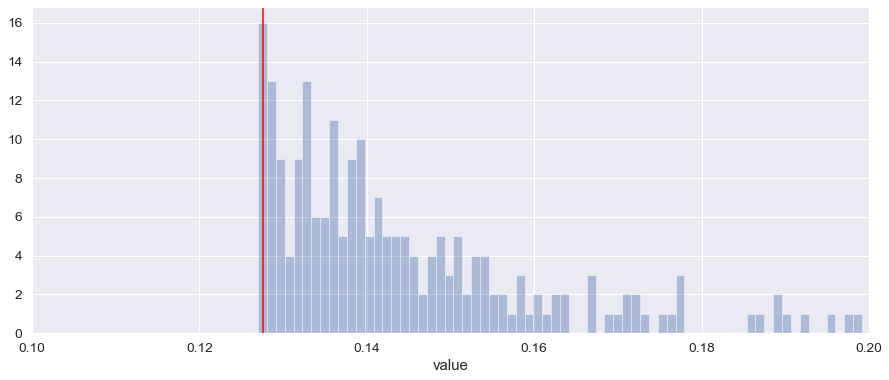

In [116]:
PT = .02
rf_study_df[rf_study_df.value == rf_study_df.value.quantile(PT, interpolation='higher')].nsmallest(1, 'value', keep='first')
rf_study_df[rf_study_df.value == rf_study_df.value.quantile(PT, interpolation='higher')].nsmallest(1, 'value', keep='first').drop('value', axis=1).to_dict(orient='records')

plt.figure(figsize=(15,6))
sns.distplot(rf_study_df.value, bins=250, kde=False)
plt.axvline(rf_study_df.value.quantile(PT, interpolation='higher'), color='red')
plt.xlim(.1,.2)

In [120]:
# tune n-estimators
rf_best_params = {'max_depth': 103,
                  'max_features': 0.10958557303135029,
                  'max_leaf_nodes': 777,
                  'max_samples': 0.9174785888820328,
                  'min_samples_leaf': 1,
                  'min_samples_split': 2}
full_pipe = make_pipeline(prep_pipe, RandomForestRegressor(n_estimators=1000, **rf_best_params))
scores = cross_val_score(full_pipe, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
np.sqrt(np.mean(-scores))    # return mean cross-validation test RMSLE (Root Mean Squared Logarithmic Error) score

0.12581456067247004

In [121]:
rf_best_score = 0.12581456067247004
rf_best_params = {'n_estimators': 1000,
                  'max_depth': 103,
                  'max_features': 0.10958557303135029,
                  'max_leaf_nodes': 777,
                  'max_samples': 0.9174785888820328,
                  'min_samples_leaf': 1,
                  'min_samples_split': 2}

In [122]:
# using early stopping, find a combination of learning_rate and n_estimators that will allow us to tune XGBoost in
# a relatively short amount of time; after the optimal hyper-parameters are determined, learning_rate will be
# decreased and n_estimators will be increased to further improve XGBoost's performance
XGBRegressor(learning_rate=.2, n_estimators=1000).fit(prep_pipe.fit_transform(X_train), y_train, eval_set=[(prep_pipe.transform(X_test), y_test)],
                                                      eval_metric='rmse', early_stopping_rounds=50)

[0]	validation_0-rmse:9.24123
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:7.40156
[2]	validation_0-rmse:5.92674
[3]	validation_0-rmse:4.74923
[4]	validation_0-rmse:3.80533
[5]	validation_0-rmse:3.04991
[6]	validation_0-rmse:2.44599
[7]	validation_0-rmse:1.96362
[8]	validation_0-rmse:1.57819
[9]	validation_0-rmse:1.27001
[10]	validation_0-rmse:1.02231
[11]	validation_0-rmse:0.82377
[12]	validation_0-rmse:0.66704
[13]	validation_0-rmse:0.54127
[14]	validation_0-rmse:0.44149
[15]	validation_0-rmse:0.36358
[16]	validation_0-rmse:0.30412
[17]	validation_0-rmse:0.25587
[18]	validation_0-rmse:0.21883
[19]	validation_0-rmse:0.19117
[20]	validation_0-rmse:0.17118
[21]	validation_0-rmse:0.15588
[22]	validation_0-rmse:0.14478
[23]	validation_0-rmse:0.13774
[24]	validation_0-rmse:0.13181
[25]	validation_0-rmse:0.12820
[26]	validation_0-rmse:0.12580
[27]	validation_0-rmse:0.12322
[28]	validation_0-rmse:0.12194
[29]	validation_0-rmse:0.12018
[30]	validation

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.2, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [123]:
# tune XGBoost hyper-parameters
def xgb_objective(trial):
    params = {"learning_rate": .2,
              'n_estimators': 141,
              'max_depth': trial.suggest_int('max_depth', 1, 30),
              "subsample": trial.suggest_uniform("subsample", 0, 1),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 250),
              'gamma': trial.suggest_uniform('gamma', 1e-15, 10),
              "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0, 1),
              'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0, 1),
              'colsample_bynode': trial.suggest_uniform('colsample_bynode', 0, 1),
              'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-15, 10),
              'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-15, 10)}
    
    full_pipe = make_pipeline(prep_pipe, XGBRegressor(**params))
    scores = cross_val_score(full_pipe, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    return np.sqrt(np.mean(-scores))    # return mean cross-validation test RMSLE (Root Mean Squared Logarithmic Error) score

xgb_study = optuna.create_study(direction='minimize')
xgb_study.optimize(xgb_objective, n_trials=250)
joblib.dump(xgb_study, 'xgb_study.pkl')

xgb_study_df = xgb_study.trials_dataframe(attrs=['value', "params", "user_attrs", "system_attrs"])
rename_columns(xgb_study_df)

[I 2020-05-24 22:08:34,908] Finished trial#0 with value: 0.2184465608690749 with parameters: {'max_depth': 8, 'subsample': 0.449111776726815, 'min_child_weight': 204, 'gamma': 2.8667550813810387, 'colsample_bytree': 0.12173264040347564, 'colsample_bylevel': 0.4552180690558254, 'colsample_bynode': 0.3292572253406314, 'reg_alpha': 0.0006494502385563703, 'reg_lambda': 1.945387030698009e-12}. Best is trial#0 with value: 0.2184465608690749.
[I 2020-05-24 22:08:40,356] Finished trial#1 with value: 0.20771323861009647 with parameters: {'max_depth': 15, 'subsample': 0.8564759776914015, 'min_child_weight': 22, 'gamma': 8.747346969830346, 'colsample_bytree': 0.22822310720912653, 'colsample_bylevel': 0.4680058198570387, 'colsample_bynode': 0.9625263292275434, 'reg_alpha': 7.111728990829395e-07, 'reg_lambda': 1.500512790897741e-12}. Best is trial#1 with value: 0.20771323861009647.
[I 2020-05-24 22:08:44,306] Finished trial#2 with value: 0.392294329923092 with parameters: {'max_depth': 13, 'subsamp

[I 2020-05-24 22:10:30,923] Finished trial#18 with value: 0.17193009205559473 with parameters: {'max_depth': 19, 'subsample': 0.6859429666353578, 'min_child_weight': 247, 'gamma': 0.001838112474941582, 'colsample_bytree': 0.806999948698822, 'colsample_bylevel': 0.9904092067567325, 'colsample_bynode': 0.5173067473504848, 'reg_alpha': 1.8003242721846999e-12, 'reg_lambda': 3.436406252488691e-15}. Best is trial#17 with value: 0.15888356929696562.
[I 2020-05-24 22:10:36,018] Finished trial#19 with value: 0.20191186509541448 with parameters: {'max_depth': 30, 'subsample': 0.5733393959976418, 'min_child_weight': 249, 'gamma': 1.2930337853020832, 'colsample_bytree': 0.8239071773599738, 'colsample_bylevel': 0.5947165076283284, 'colsample_bynode': 0.4330327463829679, 'reg_alpha': 1.556310747930137e-09, 'reg_lambda': 1.267222720699079e-15}. Best is trial#17 with value: 0.15888356929696562.
[I 2020-05-24 22:10:43,213] Finished trial#20 with value: 0.18405545507287113 with parameters: {'max_depth':

[I 2020-05-24 22:13:17,786] Finished trial#36 with value: 0.16131034196267396 with parameters: {'max_depth': 30, 'subsample': 0.9418426773010864, 'min_child_weight': 76, 'gamma': 1.7967606920312682, 'colsample_bytree': 0.19230113775729468, 'colsample_bylevel': 0.8843395389147634, 'colsample_bynode': 0.9964624808142697, 'reg_alpha': 1.5091546288566355e-08, 'reg_lambda': 3.2277392356200153e-12}. Best is trial#32 with value: 0.13803688364708347.
[I 2020-05-24 22:13:22,001] Finished trial#37 with value: 0.19368390896327747 with parameters: {'max_depth': 27, 'subsample': 0.3859761375913412, 'min_child_weight': 106, 'gamma': 0.5260028477115981, 'colsample_bytree': 0.012076815281062941, 'colsample_bylevel': 0.7261015313295738, 'colsample_bynode': 0.9173907156054018, 'reg_alpha': 5.330419211948175e-09, 'reg_lambda': 1.0461972235484542e-10}. Best is trial#32 with value: 0.13803688364708347.
[I 2020-05-24 22:13:28,097] Finished trial#38 with value: 0.16424960022218335 with parameters: {'max_dept

[I 2020-05-24 22:14:53,282] Finished trial#54 with value: 0.13773311631151453 with parameters: {'max_depth': 21, 'subsample': 0.9996161583737941, 'min_child_weight': 31, 'gamma': 0.41035808371426796, 'colsample_bytree': 0.2489045908806364, 'colsample_bylevel': 0.40843761640445464, 'colsample_bynode': 0.8069974740664021, 'reg_alpha': 5.346945902779199e-05, 'reg_lambda': 1.9402176361251204e-06}. Best is trial#42 with value: 0.13439552652479608.
[I 2020-05-24 22:15:02,621] Finished trial#55 with value: 0.14957984369955657 with parameters: {'max_depth': 21, 'subsample': 0.9551612020241655, 'min_child_weight': 30, 'gamma': 1.1163933130592254, 'colsample_bytree': 0.36522332095206755, 'colsample_bylevel': 0.4091481318463463, 'colsample_bynode': 0.9574127677918618, 'reg_alpha': 2.9903277365816927e-05, 'reg_lambda': 2.387336047438105e-06}. Best is trial#42 with value: 0.13439552652479608.
[I 2020-05-24 22:15:12,640] Finished trial#56 with value: 0.12557304425422705 with parameters: {'max_depth'

[I 2020-05-24 22:17:04,554] Finished trial#72 with value: 0.15035466822290255 with parameters: {'max_depth': 14, 'subsample': 0.8747258605546392, 'min_child_weight': 15, 'gamma': 0.681537282401008, 'colsample_bytree': 0.23159277504855857, 'colsample_bylevel': 0.4871776684286235, 'colsample_bynode': 0.1819111705642794, 'reg_alpha': 1.1165087624441083, 'reg_lambda': 0.0006197912097347992}. Best is trial#56 with value: 0.12557304425422705.
[I 2020-05-24 22:17:13,871] Finished trial#73 with value: 0.13106081668053818 with parameters: {'max_depth': 14, 'subsample': 0.8437476548150196, 'min_child_weight': 3, 'gamma': 0.0594327352695878, 'colsample_bytree': 0.5148365690226391, 'colsample_bylevel': 0.5978885398254077, 'colsample_bynode': 0.08311288285797608, 'reg_alpha': 0.0015422152809356085, 'reg_lambda': 1.9910554141931173e-06}. Best is trial#56 with value: 0.12557304425422705.
[I 2020-05-24 22:17:22,264] Finished trial#74 with value: 0.13700310270608634 with parameters: {'max_depth': 13, '

[I 2020-05-24 22:20:08,969] Finished trial#90 with value: 0.1644579285270255 with parameters: {'max_depth': 11, 'subsample': 0.7839466265468525, 'min_child_weight': 18, 'gamma': 1.1042212899849924, 'colsample_bytree': 0.2787563317914637, 'colsample_bylevel': 0.5170941158714095, 'colsample_bynode': 0.050758517785343515, 'reg_alpha': 0.07716909787925015, 'reg_lambda': 1.4729517115375743e-06}. Best is trial#56 with value: 0.12557304425422705.
[I 2020-05-24 22:20:19,646] Finished trial#91 with value: 0.1415932858792752 with parameters: {'max_depth': 15, 'subsample': 0.9355402109997748, 'min_child_weight': 31, 'gamma': 0.5062676619678956, 'colsample_bytree': 0.306440323317699, 'colsample_bylevel': 0.44314354414713514, 'colsample_bynode': 0.2711175345561705, 'reg_alpha': 1.689232990663405e-06, 'reg_lambda': 1.1333325954371085e-05}. Best is trial#56 with value: 0.12557304425422705.
[I 2020-05-24 22:20:30,514] Finished trial#92 with value: 0.13492738359079867 with parameters: {'max_depth': 13,

[I 2020-05-24 22:23:48,468] Finished trial#108 with value: 0.14320686943168698 with parameters: {'max_depth': 7, 'subsample': 0.5375190999492032, 'min_child_weight': 18, 'gamma': 0.494806771621185, 'colsample_bytree': 0.718852795480372, 'colsample_bylevel': 0.8590611036952431, 'colsample_bynode': 0.1987620084403202, 'reg_alpha': 5.426850764418759e-06, 'reg_lambda': 0.002565987295130034}. Best is trial#56 with value: 0.12557304425422705.
[I 2020-05-24 22:24:01,945] Finished trial#109 with value: 0.1350303288326799 with parameters: {'max_depth': 10, 'subsample': 0.33271950313270415, 'min_child_weight': 24, 'gamma': 0.17875436701358977, 'colsample_bytree': 0.9520521187663558, 'colsample_bylevel': 0.6816859756893207, 'colsample_bynode': 0.3211423974683019, 'reg_alpha': 1.5298224721574759e-07, 'reg_lambda': 0.0007217849362004819}. Best is trial#56 with value: 0.12557304425422705.
[I 2020-05-24 22:24:21,357] Finished trial#110 with value: 0.13099855565757815 with parameters: {'max_depth': 11

[I 2020-05-24 22:28:41,421] Finished trial#126 with value: 0.13338832451505087 with parameters: {'max_depth': 12, 'subsample': 0.6128453454967755, 'min_child_weight': 1, 'gamma': 0.0007576714869111656, 'colsample_bytree': 0.871813845349679, 'colsample_bylevel': 0.9248810285181216, 'colsample_bynode': 0.15356639495666613, 'reg_alpha': 2.2053870779805764e-08, 'reg_lambda': 0.5864259243979948}. Best is trial#56 with value: 0.12557304425422705.
[I 2020-05-24 22:28:58,098] Finished trial#127 with value: 0.20004043449010314 with parameters: {'max_depth': 15, 'subsample': 0.5523584051889483, 'min_child_weight': 23, 'gamma': 5.1211145603911135, 'colsample_bytree': 0.9447452754957527, 'colsample_bylevel': 0.9620764211376774, 'colsample_bynode': 0.12396206389291313, 'reg_alpha': 1.7670979662842223e-10, 'reg_lambda': 0.007284771505093255}. Best is trial#56 with value: 0.12557304425422705.
[I 2020-05-24 22:29:21,955] Finished trial#128 with value: 0.13241741806063845 with parameters: {'max_depth':

[I 2020-05-24 22:33:55,123] Finished trial#144 with value: 0.12968533618636252 with parameters: {'max_depth': 17, 'subsample': 0.6728268084258674, 'min_child_weight': 49, 'gamma': 0.009892985912068547, 'colsample_bytree': 0.6952195477788167, 'colsample_bylevel': 0.9719714201471913, 'colsample_bynode': 0.25865717287889806, 'reg_alpha': 2.4038111547710243e-10, 'reg_lambda': 8.656207273647174}. Best is trial#56 with value: 0.12557304425422705.
[I 2020-05-24 22:34:05,981] Finished trial#145 with value: 0.14869604092313296 with parameters: {'max_depth': 17, 'subsample': 0.6568273701895441, 'min_child_weight': 43, 'gamma': 0.424708452139732, 'colsample_bytree': 0.6958913487349438, 'colsample_bylevel': 0.9747642839714828, 'colsample_bynode': 0.2647370591426029, 'reg_alpha': 2.713633772918876e-10, 'reg_lambda': 8.590558793989011}. Best is trial#56 with value: 0.12557304425422705.
[I 2020-05-24 22:34:22,820] Finished trial#146 with value: 0.1304419787647021 with parameters: {'max_depth': 15, 's

[I 2020-05-24 22:39:54,813] Finished trial#162 with value: 0.1465936594261164 with parameters: {'max_depth': 14, 'subsample': 0.6312390799199232, 'min_child_weight': 39, 'gamma': 0.36533669785678036, 'colsample_bytree': 0.7295612357644187, 'colsample_bylevel': 0.9117856770142322, 'colsample_bynode': 0.22162919796882824, 'reg_alpha': 3.176832310185657e-10, 'reg_lambda': 0.8155341252066111}. Best is trial#56 with value: 0.12557304425422705.
[I 2020-05-24 22:40:07,196] Finished trial#163 with value: 0.13913083073309218 with parameters: {'max_depth': 15, 'subsample': 0.5902315332333926, 'min_child_weight': 33, 'gamma': 0.20897134048240296, 'colsample_bytree': 0.7722728354652567, 'colsample_bylevel': 0.9435483229061247, 'colsample_bynode': 0.2582121802572617, 'reg_alpha': 3.922493626977945e-09, 'reg_lambda': 0.34529925232609804}. Best is trial#56 with value: 0.12557304425422705.
[I 2020-05-24 22:40:19,641] Finished trial#164 with value: 0.13848891559480087 with parameters: {'max_depth': 13,

[I 2020-05-24 22:44:21,450] Finished trial#180 with value: 0.14033640033413639 with parameters: {'max_depth': 18, 'subsample': 0.7228615067625428, 'min_child_weight': 59, 'gamma': 0.18644667915259386, 'colsample_bytree': 0.5917499848941884, 'colsample_bylevel': 0.8943501241519313, 'colsample_bynode': 0.30140193689912614, 'reg_alpha': 1.4173404084661783e-12, 'reg_lambda': 9.97258036352496}. Best is trial#56 with value: 0.12557304425422705.
[I 2020-05-24 22:44:43,268] Finished trial#181 with value: 0.1317947784083894 with parameters: {'max_depth': 17, 'subsample': 0.6972743284847049, 'min_child_weight': 40, 'gamma': 0.02017538959930429, 'colsample_bytree': 0.6814130636806782, 'colsample_bylevel': 0.9542899984071738, 'colsample_bynode': 0.4226131410533589, 'reg_alpha': 2.6923371688422423e-13, 'reg_lambda': 3.072810242691919}. Best is trial#56 with value: 0.12557304425422705.
[I 2020-05-24 22:45:14,890] Finished trial#182 with value: 0.12700930584521847 with parameters: {'max_depth': 17, '

[I 2020-05-24 22:51:43,802] Finished trial#198 with value: 0.14677748831269355 with parameters: {'max_depth': 18, 'subsample': 0.7189221826076025, 'min_child_weight': 22, 'gamma': 0.5159869874978108, 'colsample_bytree': 0.6885130347098003, 'colsample_bylevel': 0.9469811852876351, 'colsample_bynode': 0.5701182406029348, 'reg_alpha': 2.0388289437056796e-13, 'reg_lambda': 9.758219828879556}. Best is trial#56 with value: 0.12557304425422705.
[I 2020-05-24 22:51:55,059] Finished trial#199 with value: 0.1331862566108915 with parameters: {'max_depth': 20, 'subsample': 0.7760888250942662, 'min_child_weight': 30, 'gamma': 0.17916377350263984, 'colsample_bytree': 0.6604001176464273, 'colsample_bylevel': 0.9018957564128076, 'colsample_bynode': 0.16831301971128765, 'reg_alpha': 1.8672061717264355e-13, 'reg_lambda': 0.8446626379671323}. Best is trial#56 with value: 0.12557304425422705.
[I 2020-05-24 22:52:14,417] Finished trial#200 with value: 0.13019058443848872 with parameters: {'max_depth': 17, 

[I 2020-05-24 22:55:28,394] Finished trial#216 with value: 0.14326668545589125 with parameters: {'max_depth': 18, 'subsample': 0.5991980534385135, 'min_child_weight': 14, 'gamma': 0.48281689256486754, 'colsample_bytree': 0.627777083955295, 'colsample_bylevel': 0.9407828319240656, 'colsample_bynode': 0.5340081017623516, 'reg_alpha': 8.716955530522792e-12, 'reg_lambda': 0.4882997739530365}. Best is trial#56 with value: 0.12557304425422705.
[I 2020-05-24 22:55:40,873] Finished trial#217 with value: 0.13179657905422568 with parameters: {'max_depth': 17, 'subsample': 0.6210884955182813, 'min_child_weight': 36, 'gamma': 0.0037729222889069003, 'colsample_bytree': 0.6026113906958593, 'colsample_bylevel': 0.9611866344516342, 'colsample_bynode': 0.3543451909304055, 'reg_alpha': 6.612031225716178e-11, 'reg_lambda': 2.5474845494107097}. Best is trial#56 with value: 0.12557304425422705.
[I 2020-05-24 22:55:48,006] Finished trial#218 with value: 0.14607381819327916 with parameters: {'max_depth': 16,

[I 2020-05-24 22:58:31,348] Finished trial#234 with value: 0.12871276024678696 with parameters: {'max_depth': 18, 'subsample': 0.6757155491789207, 'min_child_weight': 48, 'gamma': 0.013423519670257277, 'colsample_bytree': 0.6100297490632134, 'colsample_bylevel': 0.9678775625456012, 'colsample_bynode': 0.1952040500302464, 'reg_alpha': 4.150291440730619e-08, 'reg_lambda': 0.25100410344791396}. Best is trial#56 with value: 0.12557304425422705.
[I 2020-05-24 22:58:40,400] Finished trial#235 with value: 0.1490040059557416 with parameters: {'max_depth': 17, 'subsample': 0.673606438681454, 'min_child_weight': 49, 'gamma': 0.4031320362015099, 'colsample_bytree': 0.6113642719945357, 'colsample_bylevel': 0.91051187163905, 'colsample_bynode': 0.182999557239908, 'reg_alpha': 5.63008996472874e-08, 'reg_lambda': 0.08464086826779291}. Best is trial#56 with value: 0.12557304425422705.
[I 2020-05-24 22:58:48,224] Finished trial#236 with value: 0.13646794939439455 with parameters: {'max_depth': 19, 'sub

['xgb_study.pkl']

In [124]:
# best RMSLE score and corresponding hyper-parameters of XGBoost
xgb_study.best_value
xgb_study.best_params
optuna.visualization.plot_slice(xgb_study)

0.12509523149006307

{'max_depth': 16,
 'subsample': 0.854997914828594,
 'min_child_weight': 11,
 'gamma': 0.0071017475313231125,
 'colsample_bytree': 0.5700857183834487,
 'colsample_bylevel': 0.9677268111615677,
 'colsample_bynode': 0.14054791755196608,
 'reg_alpha': 8.362215722443327e-10,
 'reg_lambda': 9.259592894846891}

value  colsample_bylevel  colsample_bynode  colsample_bytree    gamma  \
242  0.127006           0.944764          0.149522          0.544275  0.01173   

     max_depth  min_child_weight     reg_alpha  reg_lambda  subsample  
242         17                12  4.079222e-10    8.980687   0.847109

[{'colsample_bylevel': 0.9447635513557164,
  'colsample_bynode': 0.14952171109512363,
  'colsample_bytree': 0.5442745239760606,
  'gamma': 0.011730035794931815,
  'max_depth': 17,
  'min_child_weight': 12,
  'reg_alpha': 4.079221535700774e-10,
  'reg_lambda': 8.980687130034116,
  'subsample': 0.8471087699820646}]

<Figure size 1080x432 with 0 Axes>

(0.1, 0.2)

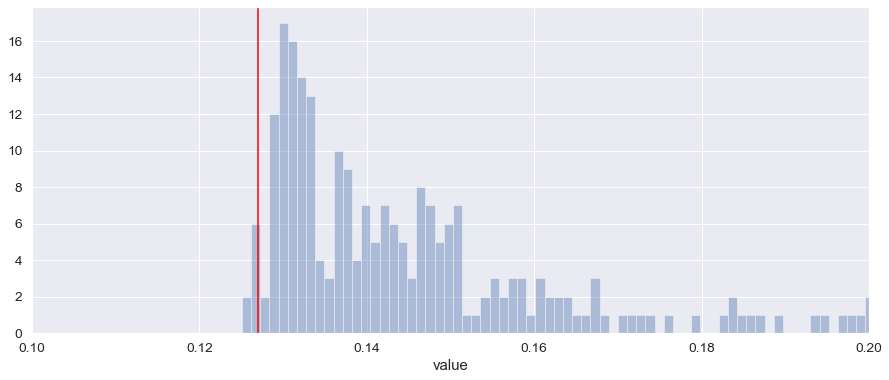

In [128]:
PT = .02
xgb_study_df[xgb_study_df.value == xgb_study_df.value.quantile(PT, interpolation='higher')].nsmallest(1, 'value', keep='first')
xgb_study_df[xgb_study_df.value == xgb_study_df.value.quantile(PT, interpolation='higher')].nsmallest(1, 'value', keep='first').drop('value', axis=1).to_dict(orient='records')

plt.figure(figsize=(15,6))
sns.distplot(xgb_study_df.value, bins=250, kde=False)
plt.axvline(xgb_study_df.value.quantile(PT, interpolation='higher'), color='red')
plt.xlim(.1,.2)

In [131]:
# using early stopping, adjust learning_rate (decrease) and n_estimators (increase) to improve performance
xgb_best_params = {'colsample_bylevel': 0.9447635513557164,
                   'colsample_bynode': 0.14952171109512363,
                   'colsample_bytree': 0.5442745239760606,
                   'gamma': 0.011730035794931815,
                   'max_depth': 17,
                   'min_child_weight': 12,
                   'reg_alpha': 4.079221535700774e-10,
                   'reg_lambda': 8.980687130034116,
                   'subsample': 0.8471087699820646}
XGBRegressor(learning_rate=.005, n_estimators=5000, **xgb_best_params).fit(prep_pipe.fit_transform(X_train), y_train, eval_set=[(prep_pipe.transform(X_test), y_test)],
                                                      eval_metric='rmse', early_stopping_rounds=250)

[0]	validation_0-rmse:11.48439
Will train until validation_0-rmse hasn't improved in 250 rounds.
[1]	validation_0-rmse:11.42767
[2]	validation_0-rmse:11.37122
[3]	validation_0-rmse:11.31506
[4]	validation_0-rmse:11.25913
[5]	validation_0-rmse:11.20355
[6]	validation_0-rmse:11.14823
[7]	validation_0-rmse:11.09318
[8]	validation_0-rmse:11.03841
[9]	validation_0-rmse:10.98393
[10]	validation_0-rmse:10.92966
[11]	validation_0-rmse:10.87567
[12]	validation_0-rmse:10.82198
[13]	validation_0-rmse:10.76851
[14]	validation_0-rmse:10.71530
[15]	validation_0-rmse:10.66241
[16]	validation_0-rmse:10.60974
[17]	validation_0-rmse:10.55736
[18]	validation_0-rmse:10.50524
[19]	validation_0-rmse:10.45339
[20]	validation_0-rmse:10.40179
[21]	validation_0-rmse:10.35042
[22]	validation_0-rmse:10.29931
[23]	validation_0-rmse:10.24846
[24]	validation_0-rmse:10.19782
[25]	validation_0-rmse:10.14749
[26]	validation_0-rmse:10.09741
[27]	validation_0-rmse:10.04759
[28]	validation_0-rmse:9.99801
[29]	validation_0

[257]	validation_0-rmse:3.24090
[258]	validation_0-rmse:3.22517
[259]	validation_0-rmse:3.20952
[260]	validation_0-rmse:3.19402
[261]	validation_0-rmse:3.17851
[262]	validation_0-rmse:3.16309
[263]	validation_0-rmse:3.14773
[264]	validation_0-rmse:3.13244
[265]	validation_0-rmse:3.11726
[266]	validation_0-rmse:3.10216
[267]	validation_0-rmse:3.08715
[268]	validation_0-rmse:3.07221
[269]	validation_0-rmse:3.05737
[270]	validation_0-rmse:3.04256
[271]	validation_0-rmse:3.02784
[272]	validation_0-rmse:3.01321
[273]	validation_0-rmse:2.99869
[274]	validation_0-rmse:2.98422
[275]	validation_0-rmse:2.96980
[276]	validation_0-rmse:2.95545
[277]	validation_0-rmse:2.94124
[278]	validation_0-rmse:2.92699
[279]	validation_0-rmse:2.91285
[280]	validation_0-rmse:2.89882
[281]	validation_0-rmse:2.88484
[282]	validation_0-rmse:2.87096
[283]	validation_0-rmse:2.85714
[284]	validation_0-rmse:2.84341
[285]	validation_0-rmse:2.82967
[286]	validation_0-rmse:2.81606
[287]	validation_0-rmse:2.80249
[288]	va

[514]	validation_0-rmse:0.96333
[515]	validation_0-rmse:0.95900
[516]	validation_0-rmse:0.95473
[517]	validation_0-rmse:0.95036
[518]	validation_0-rmse:0.94603
[519]	validation_0-rmse:0.94182
[520]	validation_0-rmse:0.93756
[521]	validation_0-rmse:0.93332
[522]	validation_0-rmse:0.92912
[523]	validation_0-rmse:0.92497
[524]	validation_0-rmse:0.92075
[525]	validation_0-rmse:0.91658
[526]	validation_0-rmse:0.91237
[527]	validation_0-rmse:0.90832
[528]	validation_0-rmse:0.90429
[529]	validation_0-rmse:0.90019
[530]	validation_0-rmse:0.89622
[531]	validation_0-rmse:0.89216
[532]	validation_0-rmse:0.88816
[533]	validation_0-rmse:0.88418
[534]	validation_0-rmse:0.88025
[535]	validation_0-rmse:0.87626
[536]	validation_0-rmse:0.87232
[537]	validation_0-rmse:0.86841
[538]	validation_0-rmse:0.86454
[539]	validation_0-rmse:0.86061
[540]	validation_0-rmse:0.85669
[541]	validation_0-rmse:0.85285
[542]	validation_0-rmse:0.84909
[543]	validation_0-rmse:0.84534
[544]	validation_0-rmse:0.84158
[545]	va

[771]	validation_0-rmse:0.33214
[772]	validation_0-rmse:0.33099
[773]	validation_0-rmse:0.32984
[774]	validation_0-rmse:0.32863
[775]	validation_0-rmse:0.32745
[776]	validation_0-rmse:0.32622
[777]	validation_0-rmse:0.32506
[778]	validation_0-rmse:0.32394
[779]	validation_0-rmse:0.32279
[780]	validation_0-rmse:0.32167
[781]	validation_0-rmse:0.32051
[782]	validation_0-rmse:0.31937
[783]	validation_0-rmse:0.31829
[784]	validation_0-rmse:0.31714
[785]	validation_0-rmse:0.31598
[786]	validation_0-rmse:0.31487
[787]	validation_0-rmse:0.31380
[788]	validation_0-rmse:0.31268
[789]	validation_0-rmse:0.31164
[790]	validation_0-rmse:0.31052
[791]	validation_0-rmse:0.30944
[792]	validation_0-rmse:0.30838
[793]	validation_0-rmse:0.30726
[794]	validation_0-rmse:0.30617
[795]	validation_0-rmse:0.30513
[796]	validation_0-rmse:0.30409
[797]	validation_0-rmse:0.30304
[798]	validation_0-rmse:0.30200
[799]	validation_0-rmse:0.30097
[800]	validation_0-rmse:0.29993
[801]	validation_0-rmse:0.29888
[802]	va

[1027]	validation_0-rmse:0.16473
[1028]	validation_0-rmse:0.16443
[1029]	validation_0-rmse:0.16413
[1030]	validation_0-rmse:0.16382
[1031]	validation_0-rmse:0.16352
[1032]	validation_0-rmse:0.16321
[1033]	validation_0-rmse:0.16298
[1034]	validation_0-rmse:0.16270
[1035]	validation_0-rmse:0.16244
[1036]	validation_0-rmse:0.16214
[1037]	validation_0-rmse:0.16187
[1038]	validation_0-rmse:0.16159
[1039]	validation_0-rmse:0.16127
[1040]	validation_0-rmse:0.16101
[1041]	validation_0-rmse:0.16073
[1042]	validation_0-rmse:0.16048
[1043]	validation_0-rmse:0.16024
[1044]	validation_0-rmse:0.15997
[1045]	validation_0-rmse:0.15969
[1046]	validation_0-rmse:0.15938
[1047]	validation_0-rmse:0.15913
[1048]	validation_0-rmse:0.15888
[1049]	validation_0-rmse:0.15861
[1050]	validation_0-rmse:0.15831
[1051]	validation_0-rmse:0.15804
[1052]	validation_0-rmse:0.15777
[1053]	validation_0-rmse:0.15753
[1054]	validation_0-rmse:0.15731
[1055]	validation_0-rmse:0.15702
[1056]	validation_0-rmse:0.15673
[1057]	val

[1276]	validation_0-rmse:0.12411
[1277]	validation_0-rmse:0.12403
[1278]	validation_0-rmse:0.12397
[1279]	validation_0-rmse:0.12391
[1280]	validation_0-rmse:0.12383
[1281]	validation_0-rmse:0.12377
[1282]	validation_0-rmse:0.12371
[1283]	validation_0-rmse:0.12364
[1284]	validation_0-rmse:0.12355
[1285]	validation_0-rmse:0.12347
[1286]	validation_0-rmse:0.12340
[1287]	validation_0-rmse:0.12332
[1288]	validation_0-rmse:0.12323
[1289]	validation_0-rmse:0.12316
[1290]	validation_0-rmse:0.12309
[1291]	validation_0-rmse:0.12302
[1292]	validation_0-rmse:0.12295
[1293]	validation_0-rmse:0.12288
[1294]	validation_0-rmse:0.12279
[1295]	validation_0-rmse:0.12273
[1296]	validation_0-rmse:0.12265
[1297]	validation_0-rmse:0.12258
[1298]	validation_0-rmse:0.12250
[1299]	validation_0-rmse:0.12242
[1300]	validation_0-rmse:0.12234
[1301]	validation_0-rmse:0.12227
[1302]	validation_0-rmse:0.12219
[1303]	validation_0-rmse:0.12213
[1304]	validation_0-rmse:0.12209
[1305]	validation_0-rmse:0.12203
[1306]	val

[1525]	validation_0-rmse:0.11240
[1526]	validation_0-rmse:0.11239
[1527]	validation_0-rmse:0.11234
[1528]	validation_0-rmse:0.11230
[1529]	validation_0-rmse:0.11227
[1530]	validation_0-rmse:0.11225
[1531]	validation_0-rmse:0.11223
[1532]	validation_0-rmse:0.11220
[1533]	validation_0-rmse:0.11217
[1534]	validation_0-rmse:0.11215
[1535]	validation_0-rmse:0.11212
[1536]	validation_0-rmse:0.11208
[1537]	validation_0-rmse:0.11207
[1538]	validation_0-rmse:0.11203
[1539]	validation_0-rmse:0.11201
[1540]	validation_0-rmse:0.11199
[1541]	validation_0-rmse:0.11196
[1542]	validation_0-rmse:0.11194
[1543]	validation_0-rmse:0.11192
[1544]	validation_0-rmse:0.11191
[1545]	validation_0-rmse:0.11189
[1546]	validation_0-rmse:0.11186
[1547]	validation_0-rmse:0.11183
[1548]	validation_0-rmse:0.11181
[1549]	validation_0-rmse:0.11179
[1550]	validation_0-rmse:0.11177
[1551]	validation_0-rmse:0.11175
[1552]	validation_0-rmse:0.11171
[1553]	validation_0-rmse:0.11169
[1554]	validation_0-rmse:0.11169
[1555]	val

[1774]	validation_0-rmse:0.10821
[1775]	validation_0-rmse:0.10821
[1776]	validation_0-rmse:0.10820
[1777]	validation_0-rmse:0.10819
[1778]	validation_0-rmse:0.10818
[1779]	validation_0-rmse:0.10817
[1780]	validation_0-rmse:0.10815
[1781]	validation_0-rmse:0.10814
[1782]	validation_0-rmse:0.10813
[1783]	validation_0-rmse:0.10811
[1784]	validation_0-rmse:0.10809
[1785]	validation_0-rmse:0.10807
[1786]	validation_0-rmse:0.10806
[1787]	validation_0-rmse:0.10805
[1788]	validation_0-rmse:0.10804
[1789]	validation_0-rmse:0.10801
[1790]	validation_0-rmse:0.10800
[1791]	validation_0-rmse:0.10800
[1792]	validation_0-rmse:0.10799
[1793]	validation_0-rmse:0.10798
[1794]	validation_0-rmse:0.10797
[1795]	validation_0-rmse:0.10796
[1796]	validation_0-rmse:0.10795
[1797]	validation_0-rmse:0.10794
[1798]	validation_0-rmse:0.10793
[1799]	validation_0-rmse:0.10792
[1800]	validation_0-rmse:0.10792
[1801]	validation_0-rmse:0.10791
[1802]	validation_0-rmse:0.10790
[1803]	validation_0-rmse:0.10789
[1804]	val

[2023]	validation_0-rmse:0.10642
[2024]	validation_0-rmse:0.10642
[2025]	validation_0-rmse:0.10642
[2026]	validation_0-rmse:0.10641
[2027]	validation_0-rmse:0.10642
[2028]	validation_0-rmse:0.10641
[2029]	validation_0-rmse:0.10640
[2030]	validation_0-rmse:0.10640
[2031]	validation_0-rmse:0.10640
[2032]	validation_0-rmse:0.10639
[2033]	validation_0-rmse:0.10638
[2034]	validation_0-rmse:0.10638
[2035]	validation_0-rmse:0.10638
[2036]	validation_0-rmse:0.10638
[2037]	validation_0-rmse:0.10638
[2038]	validation_0-rmse:0.10637
[2039]	validation_0-rmse:0.10637
[2040]	validation_0-rmse:0.10635
[2041]	validation_0-rmse:0.10635
[2042]	validation_0-rmse:0.10636
[2043]	validation_0-rmse:0.10635
[2044]	validation_0-rmse:0.10635
[2045]	validation_0-rmse:0.10635
[2046]	validation_0-rmse:0.10634
[2047]	validation_0-rmse:0.10634
[2048]	validation_0-rmse:0.10633
[2049]	validation_0-rmse:0.10633
[2050]	validation_0-rmse:0.10633
[2051]	validation_0-rmse:0.10633
[2052]	validation_0-rmse:0.10632
[2053]	val

[2272]	validation_0-rmse:0.10578
[2273]	validation_0-rmse:0.10577
[2274]	validation_0-rmse:0.10576
[2275]	validation_0-rmse:0.10575
[2276]	validation_0-rmse:0.10575
[2277]	validation_0-rmse:0.10575
[2278]	validation_0-rmse:0.10575
[2279]	validation_0-rmse:0.10575
[2280]	validation_0-rmse:0.10575
[2281]	validation_0-rmse:0.10574
[2282]	validation_0-rmse:0.10575
[2283]	validation_0-rmse:0.10575
[2284]	validation_0-rmse:0.10575
[2285]	validation_0-rmse:0.10576
[2286]	validation_0-rmse:0.10575
[2287]	validation_0-rmse:0.10575
[2288]	validation_0-rmse:0.10575
[2289]	validation_0-rmse:0.10576
[2290]	validation_0-rmse:0.10576
[2291]	validation_0-rmse:0.10577
[2292]	validation_0-rmse:0.10578
[2293]	validation_0-rmse:0.10577
[2294]	validation_0-rmse:0.10577
[2295]	validation_0-rmse:0.10578
[2296]	validation_0-rmse:0.10578
[2297]	validation_0-rmse:0.10578
[2298]	validation_0-rmse:0.10577
[2299]	validation_0-rmse:0.10577
[2300]	validation_0-rmse:0.10576
[2301]	validation_0-rmse:0.10577
[2302]	val

[2521]	validation_0-rmse:0.10551
[2522]	validation_0-rmse:0.10550
[2523]	validation_0-rmse:0.10550
[2524]	validation_0-rmse:0.10550
[2525]	validation_0-rmse:0.10551
[2526]	validation_0-rmse:0.10551
[2527]	validation_0-rmse:0.10551
[2528]	validation_0-rmse:0.10551
[2529]	validation_0-rmse:0.10551
[2530]	validation_0-rmse:0.10551
[2531]	validation_0-rmse:0.10550
[2532]	validation_0-rmse:0.10549
[2533]	validation_0-rmse:0.10549
[2534]	validation_0-rmse:0.10549
[2535]	validation_0-rmse:0.10549
[2536]	validation_0-rmse:0.10549
[2537]	validation_0-rmse:0.10549
[2538]	validation_0-rmse:0.10549
[2539]	validation_0-rmse:0.10550
[2540]	validation_0-rmse:0.10550
[2541]	validation_0-rmse:0.10550
[2542]	validation_0-rmse:0.10550
[2543]	validation_0-rmse:0.10550
[2544]	validation_0-rmse:0.10549
[2545]	validation_0-rmse:0.10549
[2546]	validation_0-rmse:0.10549
[2547]	validation_0-rmse:0.10549
[2548]	validation_0-rmse:0.10550
[2549]	validation_0-rmse:0.10550
[2550]	validation_0-rmse:0.10550
[2551]	val

[2770]	validation_0-rmse:0.10544
[2771]	validation_0-rmse:0.10544
[2772]	validation_0-rmse:0.10544
[2773]	validation_0-rmse:0.10544
[2774]	validation_0-rmse:0.10544
[2775]	validation_0-rmse:0.10544
[2776]	validation_0-rmse:0.10544
[2777]	validation_0-rmse:0.10544
[2778]	validation_0-rmse:0.10544
[2779]	validation_0-rmse:0.10543
[2780]	validation_0-rmse:0.10544
[2781]	validation_0-rmse:0.10543
[2782]	validation_0-rmse:0.10543
[2783]	validation_0-rmse:0.10544
[2784]	validation_0-rmse:0.10545
[2785]	validation_0-rmse:0.10544
[2786]	validation_0-rmse:0.10544
[2787]	validation_0-rmse:0.10544
[2788]	validation_0-rmse:0.10544
[2789]	validation_0-rmse:0.10543
[2790]	validation_0-rmse:0.10543
[2791]	validation_0-rmse:0.10542
[2792]	validation_0-rmse:0.10542
[2793]	validation_0-rmse:0.10543
[2794]	validation_0-rmse:0.10542
[2795]	validation_0-rmse:0.10541
[2796]	validation_0-rmse:0.10541
[2797]	validation_0-rmse:0.10541
[2798]	validation_0-rmse:0.10541
[2799]	validation_0-rmse:0.10540
[2800]	val

[3019]	validation_0-rmse:0.10537
[3020]	validation_0-rmse:0.10538
[3021]	validation_0-rmse:0.10538
[3022]	validation_0-rmse:0.10538
[3023]	validation_0-rmse:0.10538
[3024]	validation_0-rmse:0.10538
[3025]	validation_0-rmse:0.10538
[3026]	validation_0-rmse:0.10538
[3027]	validation_0-rmse:0.10538
[3028]	validation_0-rmse:0.10538
[3029]	validation_0-rmse:0.10538
[3030]	validation_0-rmse:0.10539
[3031]	validation_0-rmse:0.10539
[3032]	validation_0-rmse:0.10538
[3033]	validation_0-rmse:0.10538
[3034]	validation_0-rmse:0.10538
[3035]	validation_0-rmse:0.10538
[3036]	validation_0-rmse:0.10538
[3037]	validation_0-rmse:0.10537
[3038]	validation_0-rmse:0.10538
[3039]	validation_0-rmse:0.10537
[3040]	validation_0-rmse:0.10537
[3041]	validation_0-rmse:0.10537
[3042]	validation_0-rmse:0.10537
[3043]	validation_0-rmse:0.10537
[3044]	validation_0-rmse:0.10538
[3045]	validation_0-rmse:0.10538
[3046]	validation_0-rmse:0.10538
[3047]	validation_0-rmse:0.10538
[3048]	validation_0-rmse:0.10538
[3049]	val

[3268]	validation_0-rmse:0.10541
[3269]	validation_0-rmse:0.10541
[3270]	validation_0-rmse:0.10542
[3271]	validation_0-rmse:0.10541
[3272]	validation_0-rmse:0.10542
[3273]	validation_0-rmse:0.10542
[3274]	validation_0-rmse:0.10542
[3275]	validation_0-rmse:0.10541
[3276]	validation_0-rmse:0.10541
[3277]	validation_0-rmse:0.10541
[3278]	validation_0-rmse:0.10541
[3279]	validation_0-rmse:0.10541
[3280]	validation_0-rmse:0.10541
[3281]	validation_0-rmse:0.10541
[3282]	validation_0-rmse:0.10541
[3283]	validation_0-rmse:0.10541
[3284]	validation_0-rmse:0.10541
[3285]	validation_0-rmse:0.10542
[3286]	validation_0-rmse:0.10542
[3287]	validation_0-rmse:0.10542
[3288]	validation_0-rmse:0.10542
[3289]	validation_0-rmse:0.10542
[3290]	validation_0-rmse:0.10542
Stopping. Best iteration:
[3040]	validation_0-rmse:0.10537



XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=0.9447635513557164,
             colsample_bynode=0.14952171109512363,
             colsample_bytree=0.5442745239760606, gamma=0.011730035794931815,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.005, max_delta_step=0, max_depth=17,
             min_child_weight=12, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0,
             reg_alpha=4.079221535700774e-10, reg_lambda=8.980687130034116,
             scale_pos_weight=1, subsample=0.8471087699820646, tree_method=None,
             validate_parameters=False, verbosity=None)

In [132]:
# calculate CV score using same folds as every other model
full_pipe = make_pipeline(prep_pipe, XGBRegressor(learning_rate=.005, n_estimators=3040, **xgb_best_params))
scores = cross_val_score(full_pipe, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
np.sqrt(np.mean(-scores))    # return mean cross-validation test RMSLE (Root Mean Squared Logarithmic Error) score

0.11784347629704721

In [133]:
xgb_best_score = 0.11784347629704721
xgb_best_params = {'learning_rate': 0.005,
                   'n_estimators': 3040,
                   'colsample_bylevel': 0.9447635513557164,
                   'colsample_bynode': 0.14952171109512363,
                   'colsample_bytree': 0.5442745239760606,
                   'gamma': 0.011730035794931815,
                   'max_depth': 17,
                   'min_child_weight': 12,
                   'reg_alpha': 4.079221535700774e-10,
                   'reg_lambda': 8.980687130034116,
                   'subsample': 0.8471087699820646}

<Figure size 1080x432 with 0 Axes>

RMSLE
KNN  0.147349
SVR  0.128142
RF   0.125815
XGB  0.117843

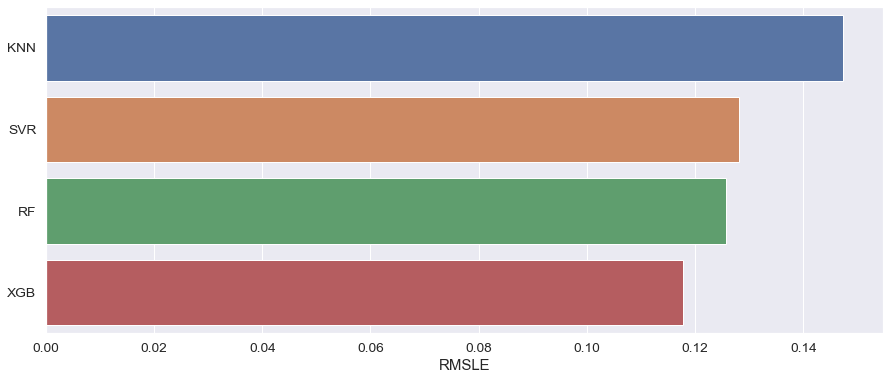

In [134]:
best_scores = pd.DataFrame(data=[knn_best_score, svr_best_score, rf_best_score, xgb_best_score], index=['KNN', 'SVR', 'RF', 'XGB'],
                           columns=['RMSLE'])
plt.figure(figsize=(15,6))
best_scores.sort_values('RMSLE', ascending=False)
sns.barplot(best_scores.sort_values('RMSLE', ascending=False).RMSLE, best_scores.sort_values('RMSLE', ascending=False).index)

In [135]:
# create an array of out-of-bag predictions for each of the four models (with tuned hyperparameters from above)
# then, concatenate them into a single array (X_train_oob)
# the final estimator of the stack will be tuned on these predictions
knn_oob = cross_val_predict(make_pipeline(prep_pipe, KNeighborsRegressor(**knn_best_params)), X_train, y_train, cv=cv, n_jobs=-1)
svr_oob = cross_val_predict(make_pipeline(prep_pipe, SVR(**svr_best_params)), X_train, y_train, cv=cv, n_jobs=-1)
rf_oob = cross_val_predict(make_pipeline(prep_pipe, RandomForestRegressor(**rf_best_params)), X_train, y_train, cv=cv, n_jobs=-1)
xgb_oob = cross_val_predict(make_pipeline(prep_pipe, XGBRegressor(**xgb_best_params)), X_train, y_train, cv=cv, n_jobs=-1)
X_train_oob = (pd.DataFrame(data=[knn_oob, svr_oob, rf_oob, xgb_oob], index=['KNN', 'SVR', 'RF', 'XGB'], columns=X_train.index)).T

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Correlations among OOB predictions of different models')

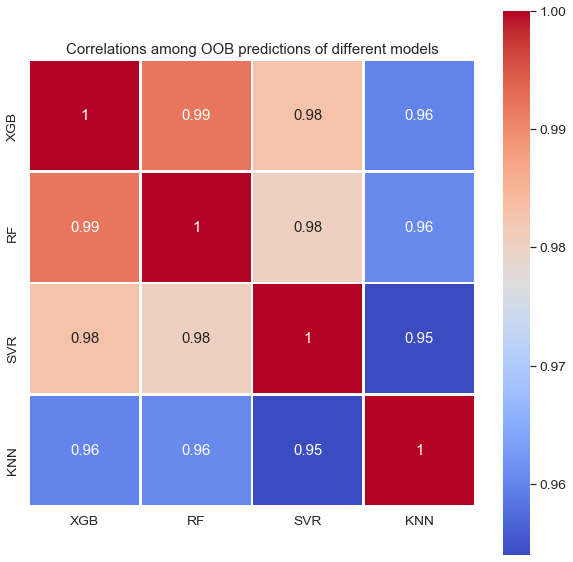

In [146]:
plt.figure(figsize=(10,10))
plt.title('Correlations among OOB predictions of different models')
sns.heatmap(X_train_oob.corr().sort_values('XGB', ascending=False, axis=1).sort_values('XGB', ascending=False, axis=0), annot=True, square=True, linewidths=1.5, cmap='coolwarm')

Unsurprisingly, the predictions of the two tree-based models (XGBoost and Random Forest) are highly correlated. Hence, keeping both of them in the stack is unlikely to improve performance by a lot. However, we will keep them both, as the additional computational expense is not an issue.

On the other hand, the predictions of k-Nearest Neighbors are relatively weakly correlated with the rest of the models. This is a sign it might be very useful to have KNN in the stack –– unless, of course, its lower RMSLE score pulls the performance of the entire stack down.

## Meta-Model

In [157]:
# tune hyper-parameters of the final model of the stack
def metamodel_objective(trial):
    params = {'alpha': trial.suggest_loguniform('alpha', 1e-15, 10)}
    
    scores = cross_val_score(Lasso(**params), X_train_oob, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    return np.sqrt(np.mean(-scores))    # return mean cross-validation test RMSLE (Root Mean Squared Logarithmic Error) score
    
metamodel_study = optuna.create_study(direction='minimize')
metamodel_study.optimize(metamodel_objective, n_trials=100)
joblib.dump(metamodel_study, 'metamodel_study.pkl')

metamodel_study_df = metamodel_study.trials_dataframe(attrs=['value', "params", "user_attrs", "system_attrs"])
rename_columns(metamodel_study_df)

[I 2020-05-24 23:25:14,324] Finished trial#0 with value: 0.11685173627486706 with parameters: {'alpha': 2.1014356701404753e-08}. Best is trial#0 with value: 0.11685173627486706.
[I 2020-05-24 23:25:14,506] Finished trial#1 with value: 0.11681462340450094 with parameters: {'alpha': 9.674432995490706e-05}. Best is trial#1 with value: 0.11681462340450094.
[I 2020-05-24 23:25:14,685] Finished trial#2 with value: 0.11685174978733594 with parameters: {'alpha': 6.4542062270753066e-12}. Best is trial#1 with value: 0.11681462340450094.
[I 2020-05-24 23:25:14,849] Finished trial#3 with value: 0.1168510562086944 with parameters: {'alpha': 4.57585618187127e-07}. Best is trial#1 with value: 0.11681462340450094.
[I 2020-05-24 23:25:15,014] Finished trial#4 with value: 0.11684926473614081 with parameters: {'alpha': 1.5855265057271634e-06}. Best is trial#1 with value: 0.11681462340450094.
[I 2020-05-24 23:25:15,173] Finished trial#5 with value: 0.11680775169754151 with parameters: {'alpha': 0.00042613

[I 2020-05-24 23:25:22,350] Finished trial#46 with value: 0.11681610496214571 with parameters: {'alpha': 2.6508820389939577e-05}. Best is trial#34 with value: 0.11680773718859062.
[I 2020-05-24 23:25:22,507] Finished trial#47 with value: 0.11719622722023589 with parameters: {'alpha': 0.003680335803384803}. Best is trial#34 with value: 0.11680773718859062.
[I 2020-05-24 23:25:22,687] Finished trial#48 with value: 0.11685167260914239 with parameters: {'alpha': 6.218295245765827e-08}. Best is trial#34 with value: 0.11680773718859062.
[I 2020-05-24 23:25:22,867] Finished trial#49 with value: 0.11681586270478571 with parameters: {'alpha': 5.2715305655415054e-05}. Best is trial#34 with value: 0.11680773718859062.
[I 2020-05-24 23:25:23,046] Finished trial#50 with value: 0.11685174979274159 with parameters: {'alpha': 5.534534575633972e-13}. Best is trial#34 with value: 0.11680773718859062.
[I 2020-05-24 23:25:23,205] Finished trial#51 with value: 0.11680868960623222 with parameters: {'alpha':

[I 2020-05-24 23:25:29,846] Finished trial#91 with value: 0.11680802397006014 with parameters: {'alpha': 0.0005052709429400169}. Best is trial#81 with value: 0.11680766747551134.
[I 2020-05-24 23:25:30,002] Finished trial#92 with value: 0.11683062224375462 with parameters: {'alpha': 1.353523076055216e-05}. Best is trial#81 with value: 0.11680766747551134.
[I 2020-05-24 23:25:30,164] Finished trial#93 with value: 0.11680825450987305 with parameters: {'alpha': 0.0003133527151318144}. Best is trial#81 with value: 0.11680766747551134.
[I 2020-05-24 23:25:30,324] Finished trial#94 with value: 0.11683674559555603 with parameters: {'alpha': 0.0014408555227681406}. Best is trial#81 with value: 0.11680766747551134.
[I 2020-05-24 23:25:30,482] Finished trial#95 with value: 0.18881700731868797 with parameters: {'alpha': 0.05421239848449469}. Best is trial#81 with value: 0.11680766747551134.
[I 2020-05-24 23:25:30,643] Finished trial#96 with value: 0.11681259353869994 with parameters: {'alpha': 0.

['metamodel_study.pkl']

In [159]:
# best RMSLE score and corresponding hyper-parameters of the final model in the stack
metamodel_study.best_value
metamodel_study.best_params
optuna.visualization.plot_slice(metamodel_study)

0.11680766747551134

{'alpha': 0.0004257637378260894}

value   alpha
34  0.116808  0.0004

[{'alpha': 0.00040022939022422565}]

<Figure size 1080x432 with 0 Axes>

(0.11, 0.14)

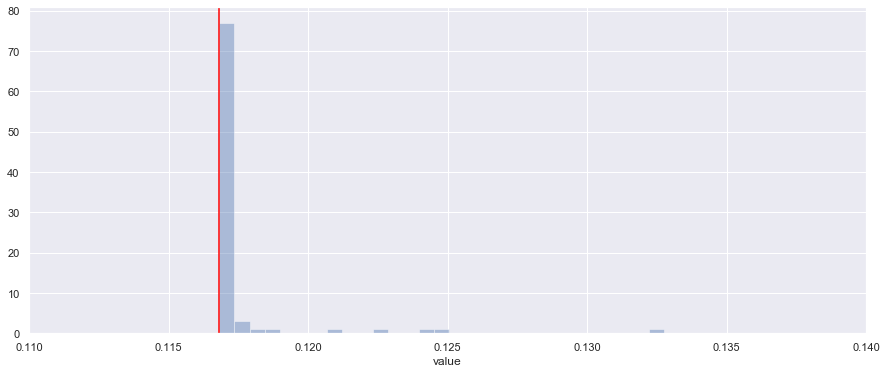

In [160]:
PT = .02
metamodel_study_df[metamodel_study_df.value == metamodel_study_df.value.quantile(PT, interpolation='higher')].nsmallest(1, 'value', keep='first')
metamodel_study_df[metamodel_study_df.value == metamodel_study_df.value.quantile(PT, interpolation='higher')].nsmallest(1, 'value', keep='first').drop('value', axis=1).to_dict(orient='records')

plt.figure(figsize=(15,6))
sns.distplot(metamodel_study_df.value, bins=500, kde=False)
plt.axvline(metamodel_study_df.value.quantile(PT, interpolation='higher'), color='red')
plt.xlim(.11,.14)

In [161]:
stack_best_score = 0.116808
metamodel_best_params = {'alpha': 0.00040022939022422565}

RMSLE
KNN    0.147349
SVR    0.128142
RF     0.125815
XGB    0.117843
Stack  0.116808

<Figure size 1080x432 with 0 Axes>

(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16]),
 <a list of 9 Text xticklabel objects>)

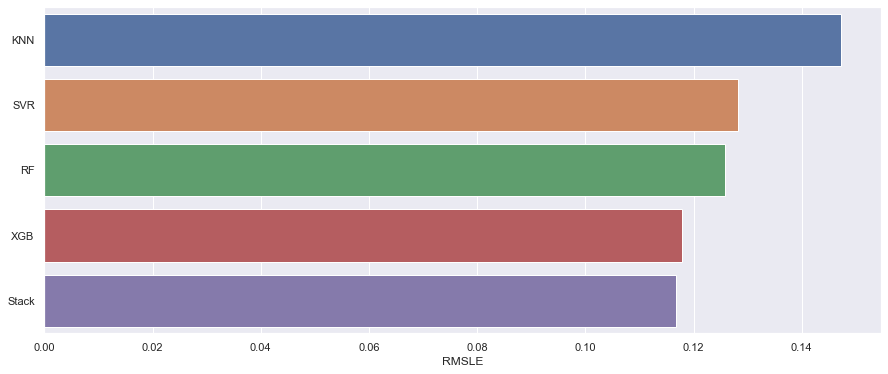

In [162]:
best_scores.loc['Stack', 'RMSLE'] = stack_best_score
best_scores.sort_values('RMSLE', ascending=False)
plt.figure(figsize=(15,6))
sns.barplot(best_scores.sort_values('RMSLE', ascending=False).RMSLE, best_scores.sort_values('RMSLE', ascending=False).index)
plt.xticks()

As the bar plot above demonstrates, our stack has produced the best score (albeit by a small margin) out of all the models we have tried. It has allowed us to shave 0.001 off the RMSLE score of our best performing model (XGBoost) and 0.009 off the RMSLE score of the second best performing model (Random Forest).

In [163]:
# combine preprocessing pipeline, four level-1 models, and meta-model into a stack
# this way we will have the entire model in one place (stack_pipe)
stack = StackingRegressor([('knn', KNeighborsRegressor(**knn_best_params)),
                           ('svr', SVR(**svr_best_params)),
                           ('rf', RandomForestRegressor(**rf_best_params)),
                           ('xgb', XGBRegressor(**xgb_best_params))],
                          final_estimator=Lasso(**metamodel_best_params),
                          passthrough=False)
stack_pipe = make_pipeline(prep_pipe, stack)

# Final Submission

In [164]:
# before making predictions on predict set for submission, let's calculate error on held-out test set (X_test, y_test)
stack_pipe.fit(X_train, y_train)    # fit stack on X_train, y_train
X_test_predictions = stack_pipe.predict(X_test)    # make predictions on X_test
mean_squared_error(y_test, X_test_predictions, squared=False)    # RMSLE

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0, transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                         

0.10475793638652242

The Root Mean Squared Error of the stack on the held out test set (X_test) is even lower than its cross validation score. The test score is 0.104757 while the cross validation score is 0.116808. This confirms that cross validation and hyper-parameter tuning have been done properly, i.e. without overfitting to the validation folds.

In [165]:
# make predictions on predict set for submission
stack_pipe.fit(X, y)    # fit stack on all available ground truth data, i.e. (X_train + X_test, y_train + y_test)
predictions = stack_pipe.predict(predict)    # make predictions for submission; revert logs of SalePrice back to SalePrice
predictions = np.expm1(predictions)
# prepare submission file with Id's and corresponding final predictions
predictions = pd.DataFrame({'Id': predict_ids, "SalePrice": predictions})
predictions.to_csv('predictions.csv', index=False)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0, transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                         